In [3]:
library('DESeq2')
library('MASS')
library('dplyr')
library('ggplot2')
library('anomalize')

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

In [5]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
t_palette <- c('darkgreen', 'mediumpurple4')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
y_palette <- c('dodgerblue4', 'springgreen1', '#cc77ff')
r_palette <- viridisLite::viridis(9)

In [6]:
treatments <- read.csv('1719_treatments.csv')
load('/xfs2/zachary.n.harris/MtVernon_sam/2019/1719_VSD_counts_varFilt.Rdata')

In [7]:
treatments$Rootstock <- factor(treatments$Rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
treatments$Irrigation <- factor(treatments$Irrigation, levels=c('None', 'RDI', 'Full'))
treatments$Phenology <- factor(treatments$Phenology, levels=c('Anthesis', 'Veraison', 'Harvest'))
treatments$Tissue <- factor(treatments$Tissue, levels=c('Leaf', 'Reproductive'))
treatments$Row <- as.factor(treatments$Row)
treatments$Year <- as.factor(treatments$Year)

## High Level Overview of Gene Expression Variation

Here I extract genes of high variance, medium variance, and then all genes in order to see where the majority of variation is partitioned in the experiment. For each set, I plot the top 2 PCs as filled in by year, phenlogical stage, rootstock, tissue, and the row in the vineyard. 

In [5]:
# extract some high variation genes to benchmark

geneVar <- apply(vsd_counts_varFilt, 2, sd)
quants <- quantile(geneVar, probs=seq(0, 1, 0.01))

cutoff90 <- as.double(quants['90%'])

geneVar_filt = rep(FALSE, length(geneVar))
geneVar_filt[geneVar > cutoff90] <- TRUE
sum(geneVar_filt)

vsd90 <- vsd_counts_varFilt[,geneVar_filt]

cutoff45 <- as.double(quants['45%'])
cutoff55 <- as.double(quants['55%'])
geneVar_filt = rep(FALSE, length(geneVar))
geneVar_filt[geneVar > cutoff45 & geneVar < cutoff55] <- TRUE
sum(geneVar_filt)

vsd45 <- vsd_counts_varFilt[,geneVar_filt]

[1] 2440

[1] 2440

In [91]:
# check_outlier <- function(gene){
#     d <- data.frame(gene=gene)
#     d <- as.data.frame(anomalize(data=as_tibble(d), target=gene, alpha=0.03, max_anoms=0.1))
#     d <- d[which(d$anomaly == 'No'),]
#     if (sd(d$gene) == 0){
#         return (0) 
#     } else {
#         return (1)
#     }
# }

# outliersRemoved_var <- apply(X=vsd, MARGIN=2, FUN=check_outlier)

In [92]:
# sum(outliersRemoved_var)

[1] 10597

In [93]:
# vsd <- vsd[which(outliersRemoved_var == 1)]
# dim(vsd)

[1]   832 10597

### First, the most variable genes (> 90th %ile)

In [6]:
pca90 <- prcomp(vsd90, center=TRUE, scale=TRUE)
summary(pca90)
for_plot <- as.data.frame(pca90$x) %>% select(PC1:PC10)
for_plot$sampleName <- rownames(for_plot)
for_plot <- merge(treatments, for_plot, on='sampleName')

Importance of components:
                           PC1     PC2     PC3    PC4     PC5     PC6     PC7
Standard deviation     31.0748 24.7968 17.8933 9.0954 7.62698 7.08507 5.96736
Proportion of Variance  0.3958  0.2520  0.1312 0.0339 0.02384 0.02057 0.01459
Cumulative Proportion   0.3958  0.6478  0.7790 0.8129 0.83672 0.85729 0.87189
                           PC8     PC9    PC10    PC11   PC12    PC13   PC14
Standard deviation     4.84791 4.59302 3.97946 3.78861 3.5605 3.28833 3.2008
Proportion of Variance 0.00963 0.00865 0.00649 0.00588 0.0052 0.00443 0.0042
Cumulative Proportion  0.88152 0.89016 0.89665 0.90254 0.9077 0.91216 0.9164
                          PC15   PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     3.05559 2.8797 2.43184 2.33232 2.19057 2.14492 1.99370
Proportion of Variance 0.00383 0.0034 0.00242 0.00223 0.00197 0.00189 0.00163
Cumulative Proportion  0.92019 0.9236 0.92601 0.92824 0.93021 0.93209 0.93372
                          PC22    PC23    

png 
  2

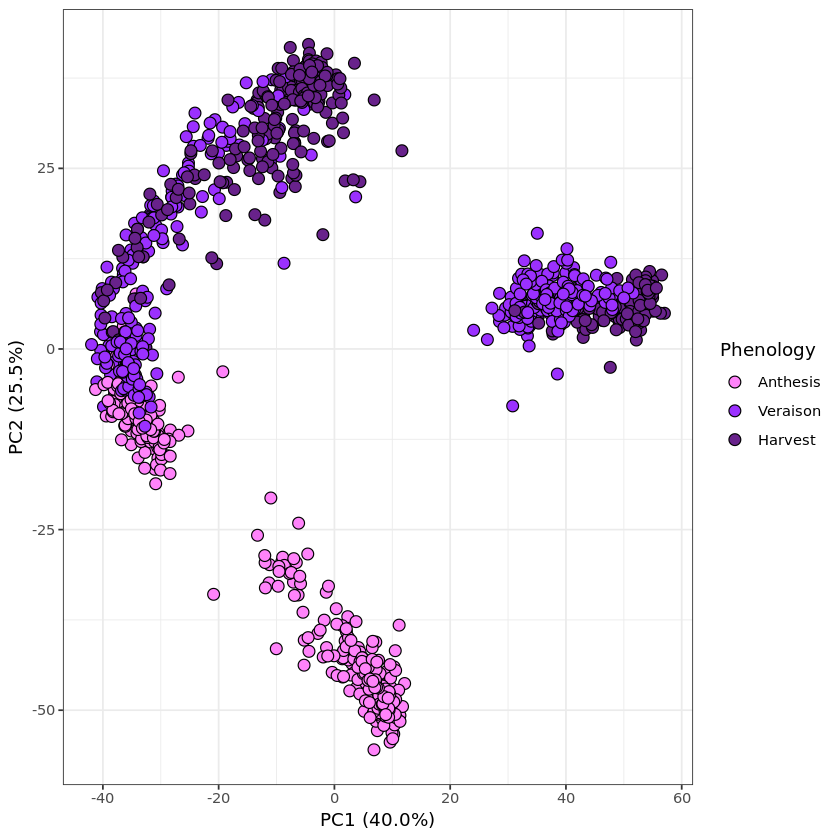

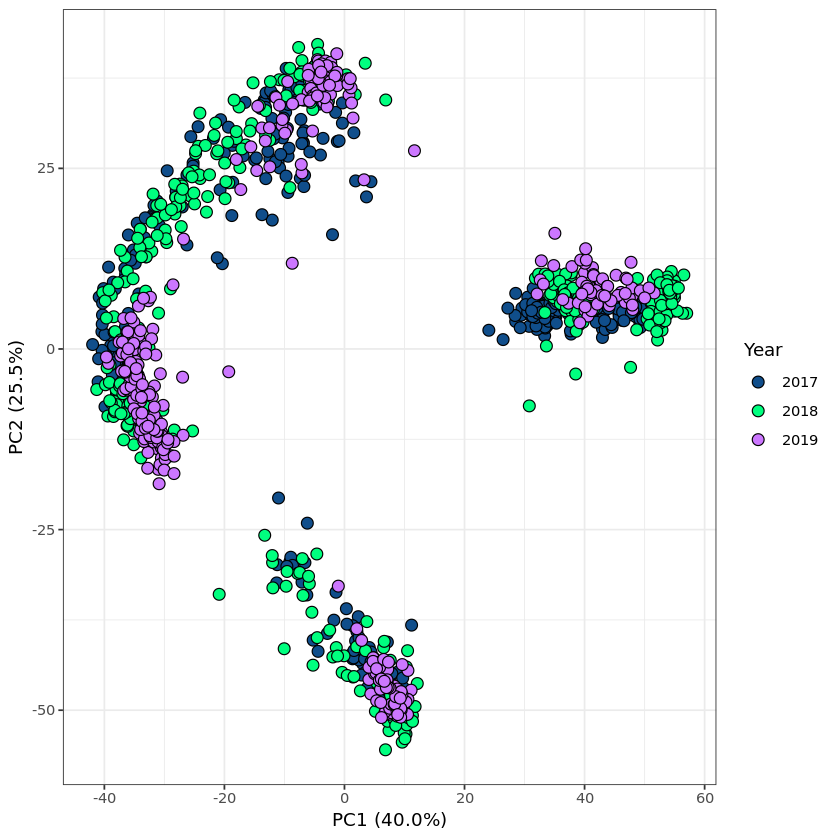

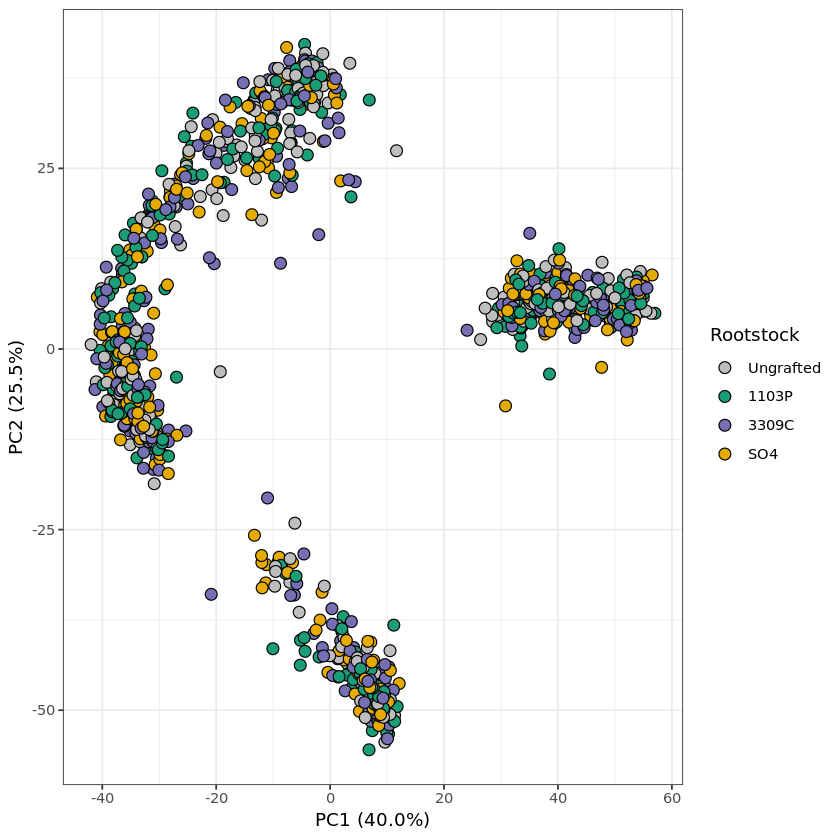

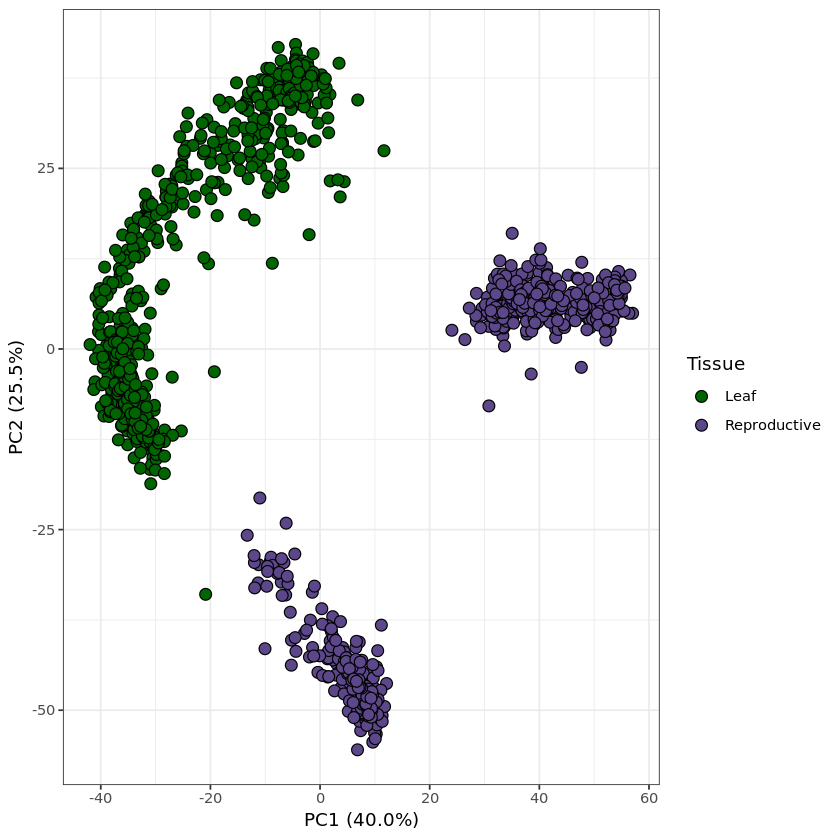

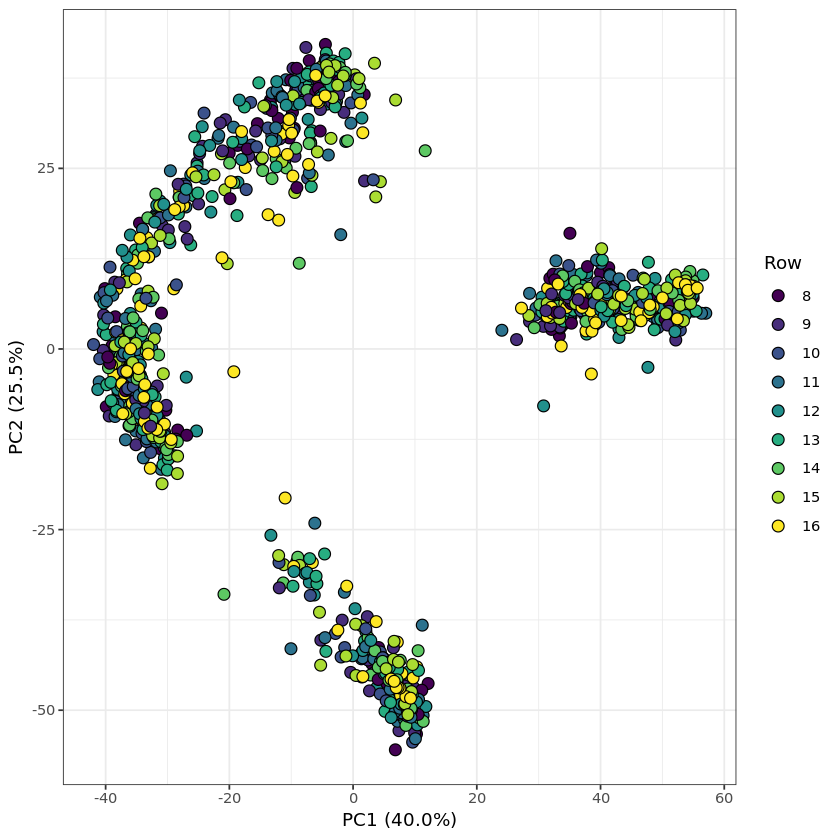

In [26]:
a <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology, shape=Phenology)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  scale_fill_manual(values=p_palette) + 
  xlab("PC1 (40.0%)") + ylab("PC2 (25.5%)") + 
  theme_bw()

b <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Year, shape=Year)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  scale_fill_manual(values=y_palette) + 
  xlab("PC1 (40.0%)") + ylab("PC2 (25.5%)") +
  theme_bw()

c <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) + 
  scale_fill_manual(values=rs_palette) + 
  xlab("PC1 (40.0%)") + ylab("PC2 (25.5%)") +
  theme_bw()

d <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Tissue, shape=Tissue)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 2)) + 
  scale_fill_manual(values=t_palette) + 
  xlab("PC1 (40.0%)") + ylab("PC2 (25.5%)") +
  theme_bw()

e <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row, shape=Row)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=r_palette) + 
  xlab("PC1 (40.0%)") + ylab("PC2 (25.5%)") +
  theme_bw()

pdf("1719_geneExpression_PCA_top10percentVar.pdf", width=22, height=4)
  ggpubr::ggarrange(a, b, c, d, e, legend=T, ncol=5)
dev.off()
a
b
c
d
e

### Second, the middlest most variable genes (45th > g > 55th %ile)

In [8]:
pca45 <- prcomp(vsd45, center=TRUE, scale=TRUE)
summary(pca45)
for_plot <- as.data.frame(pca45$x) %>% select(PC1:PC10)
for_plot$sampleName <- rownames(for_plot)
for_plot <- merge(treatments, for_plot, on='sampleName')

Importance of components:
                           PC1     PC2     PC3      PC4      PC5     PC6
Standard deviation     21.7060 16.5335 14.8930 14.07372 10.36230 9.77728
Proportion of Variance  0.1931  0.1120  0.0909  0.08118  0.04401 0.03918
Cumulative Proportion   0.1931  0.3051  0.3960  0.47720  0.52121 0.56039
                           PC7     PC8    PC9    PC10    PC11    PC12    PC13
Standard deviation     8.18802 7.51365 6.3260 5.61156 5.43157 4.62235 4.33698
Proportion of Variance 0.02748 0.02314 0.0164 0.01291 0.01209 0.00876 0.00771
Cumulative Proportion  0.58787 0.61100 0.6274 0.64031 0.65240 0.66116 0.66887
                          PC14    PC15    PC16    PC17    PC18    PC19    PC20
Standard deviation     4.07969 3.64290 3.55072 3.42475 3.26258 3.07886 2.98600
Proportion of Variance 0.00682 0.00544 0.00517 0.00481 0.00436 0.00388 0.00365
Cumulative Proportion  0.67569 0.68113 0.68629 0.69110 0.69546 0.69935 0.70300
                          PC21    PC22    PC23    PC24

png 
  2

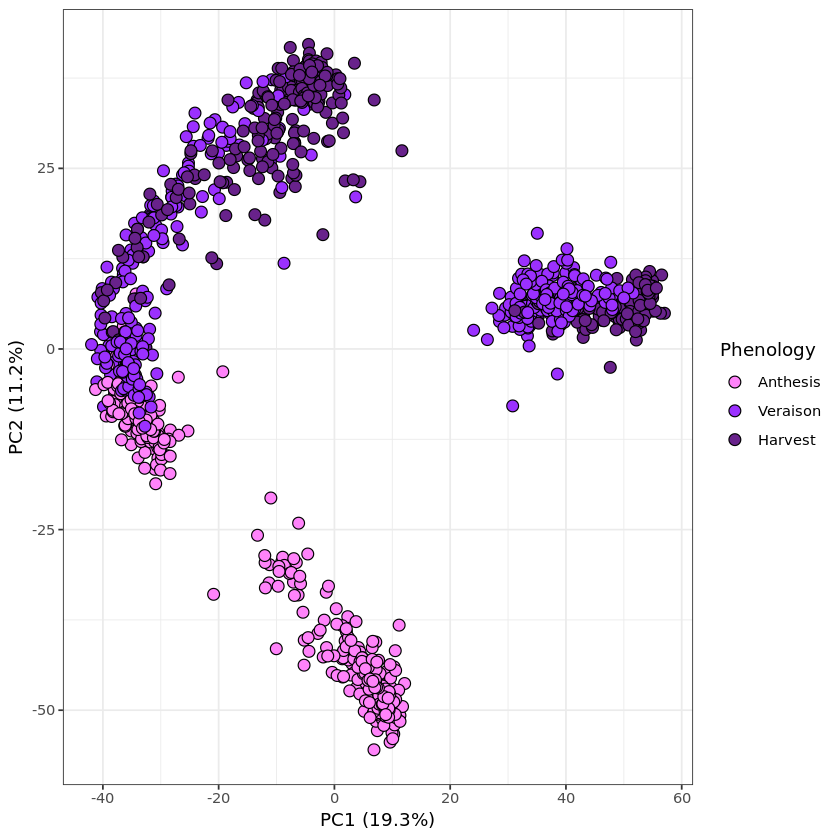

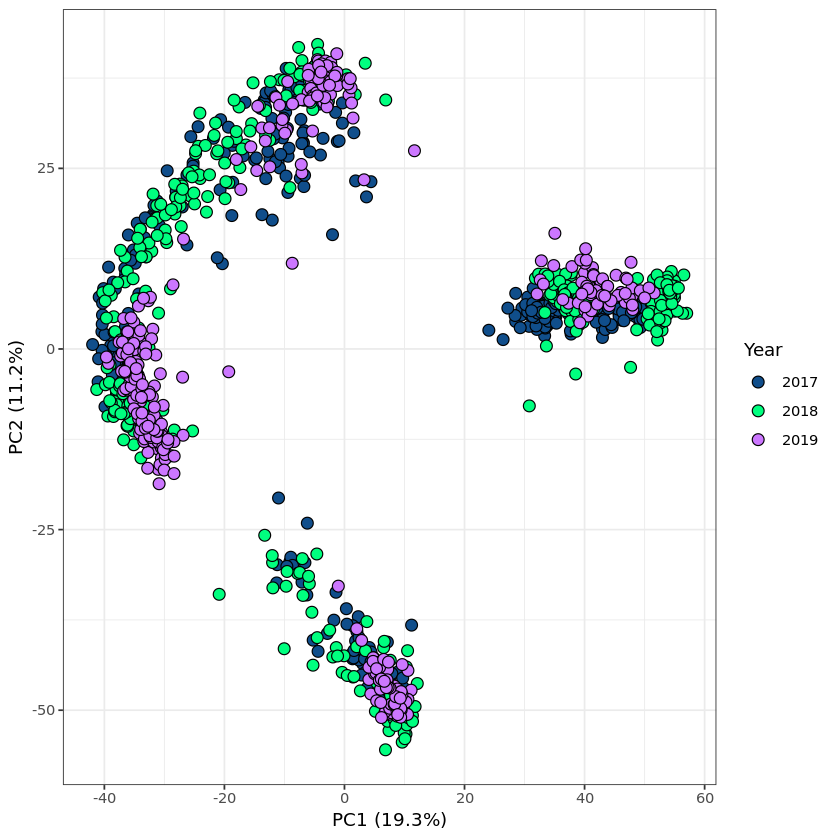

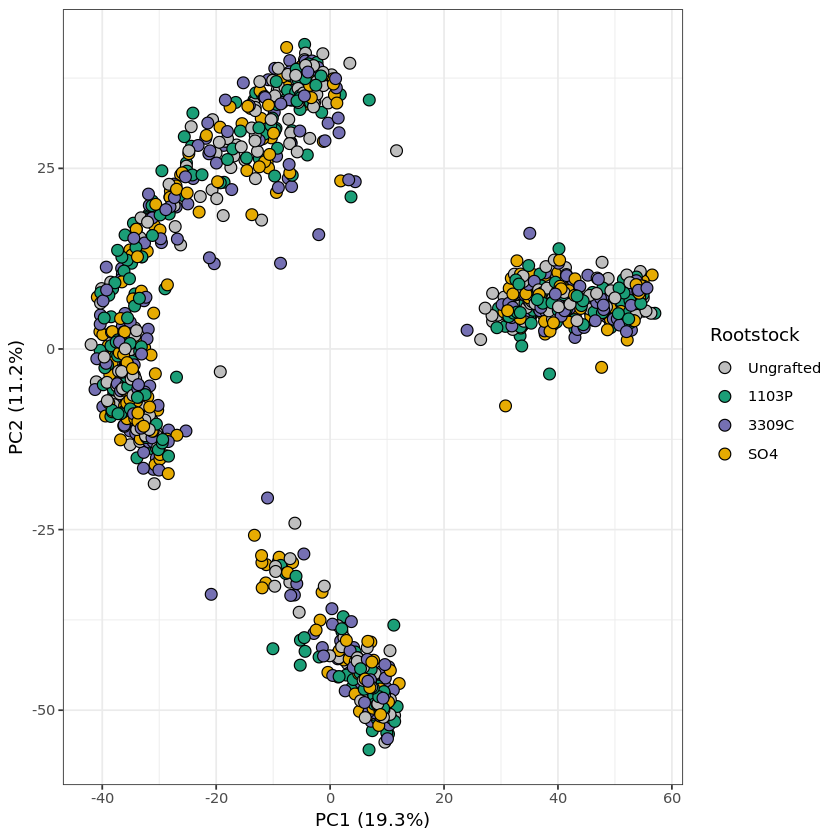

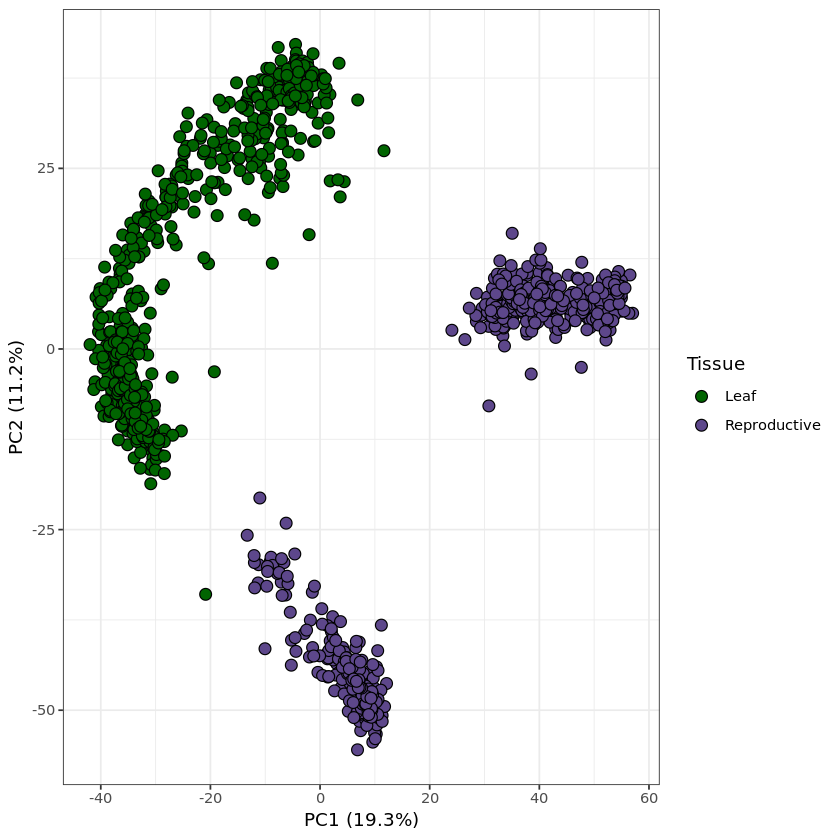

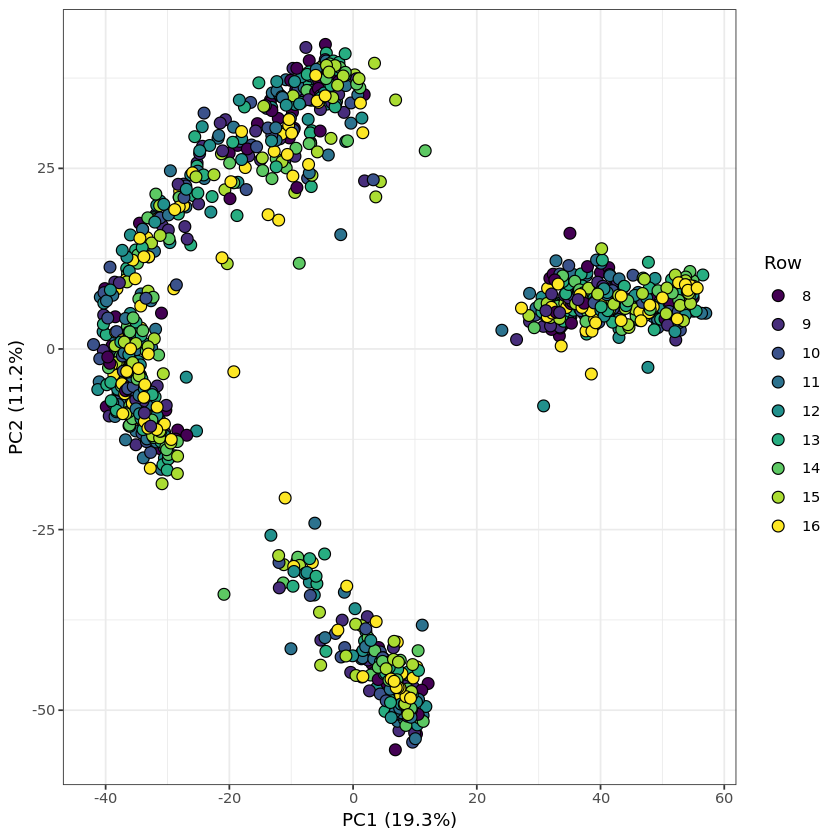

In [27]:
f <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology, shape=Phenology)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  scale_fill_manual(values=p_palette) +
  xlab("PC1 (19.3%)") + ylab("PC2 (11.2%)") +
  theme_bw()

g <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Year, shape=Year)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  scale_fill_manual(values=y_palette) + 
  xlab("PC1 (19.3%)") + ylab("PC2 (11.2%)") +
  theme_bw()

h <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) + 
  scale_fill_manual(values=rs_palette) + 
  xlab("PC1 (19.3%)") + ylab("PC2 (11.2%)") +
  theme_bw()

i <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Tissue, shape=Tissue)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 2)) + 
  scale_fill_manual(values=t_palette) + 
  xlab("PC1 (19.3%)") + ylab("PC2 (11.2%)") +
  theme_bw()

j <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row, shape=Row)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=r_palette) + 
  xlab("PC1 (19.3%)") + ylab("PC2 (11.2%)") +
  theme_bw()

pdf("1719_geneExpression_PCA_45-55percentileVar.pdf", width=22, height=4)
  ggpubr::ggarrange(f, g, h, i, j, ncol=5)
dev.off()
f
g
h
i
j

### Finally, all genes with sd > 0

In [28]:
pca <- prcomp(vsd_counts_varFilt, center=TRUE, scale=TRUE)
summary(pca)
for_plot <- as.data.frame(pca$x) %>% select(PC1:PC10)
for_plot$sampleName <- rownames(for_plot)
for_plot <- merge(treatments, for_plot, on='sampleName')

Importance of components:
                           PC1     PC2      PC3      PC4      PC5     PC6
Standard deviation     68.9952 54.9056 43.24631 37.47349 29.70248 26.0398
Proportion of Variance  0.1952  0.1236  0.07667  0.05757  0.03617  0.0278
Cumulative Proportion   0.1952  0.3187  0.39542  0.45300  0.48916  0.5170
                           PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     23.3205 21.29272 18.35058 16.17725 15.27507 13.32489
Proportion of Variance  0.0223  0.01859  0.01381  0.01073  0.00957  0.00728
Cumulative Proportion   0.5393  0.55785  0.57165  0.58238  0.59195  0.59923
                           PC13     PC14     PC15     PC16    PC17    PC18
Standard deviation     12.66662 11.85141 10.98523 10.61955 9.99226 9.81558
Proportion of Variance  0.00658  0.00576  0.00495  0.00462 0.00409 0.00395
Cumulative Proportion   0.60580  0.61156  0.61651  0.62113 0.62523 0.62918
                         PC19    PC20    PC21    PC22    PC23    PC24    P

png 
  2

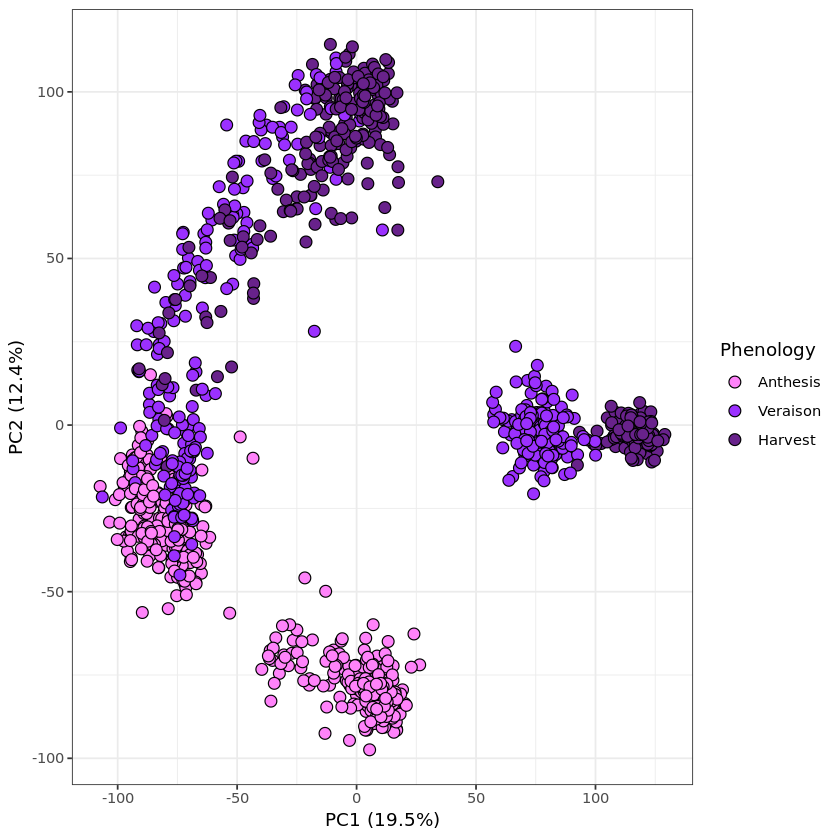

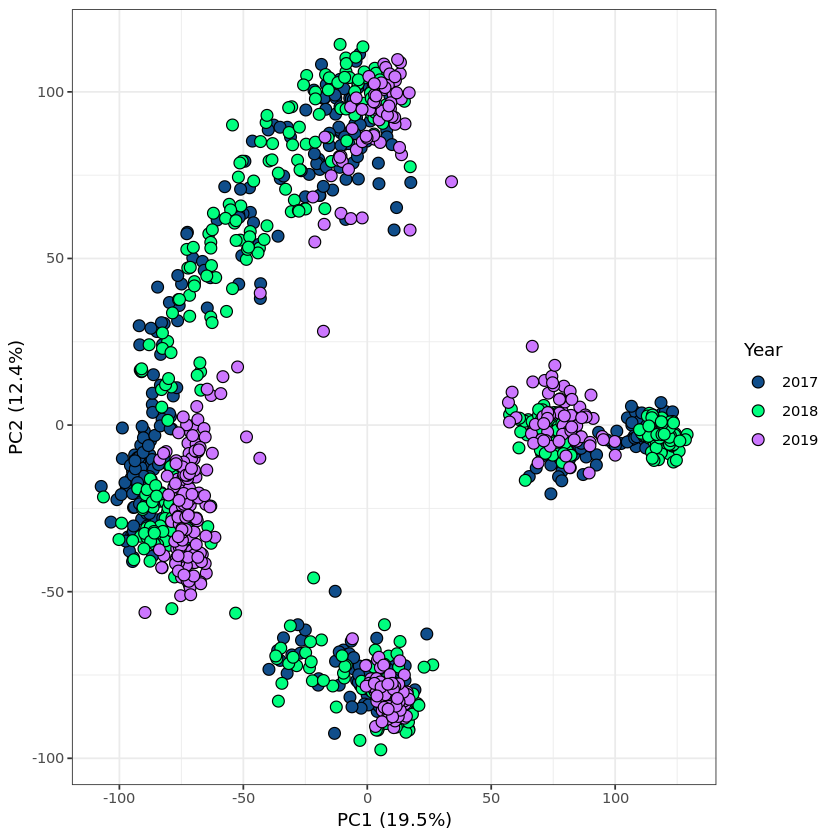

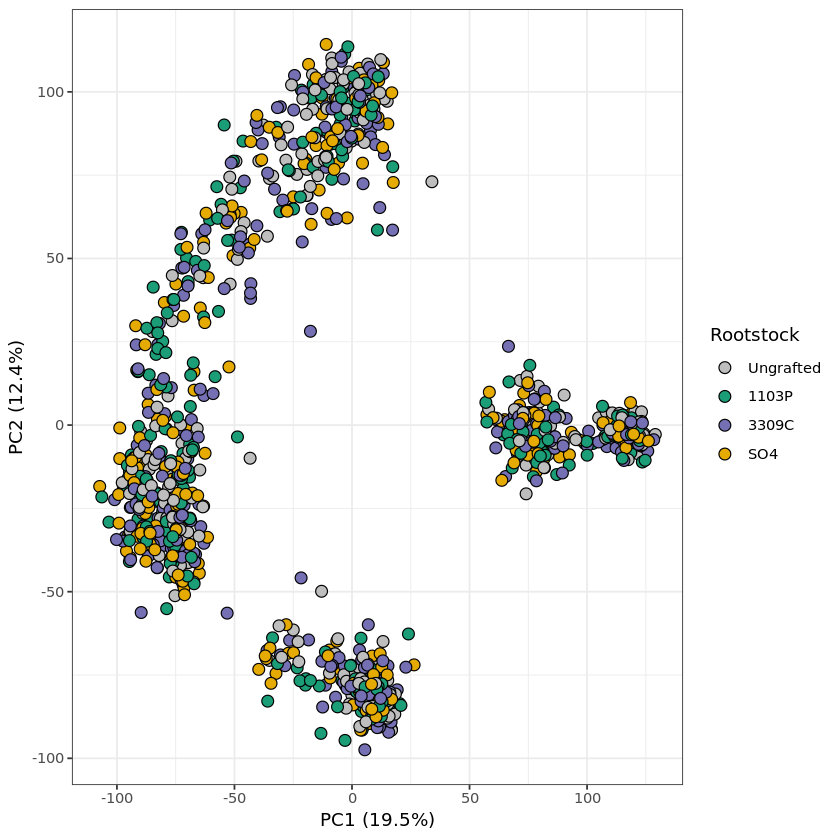

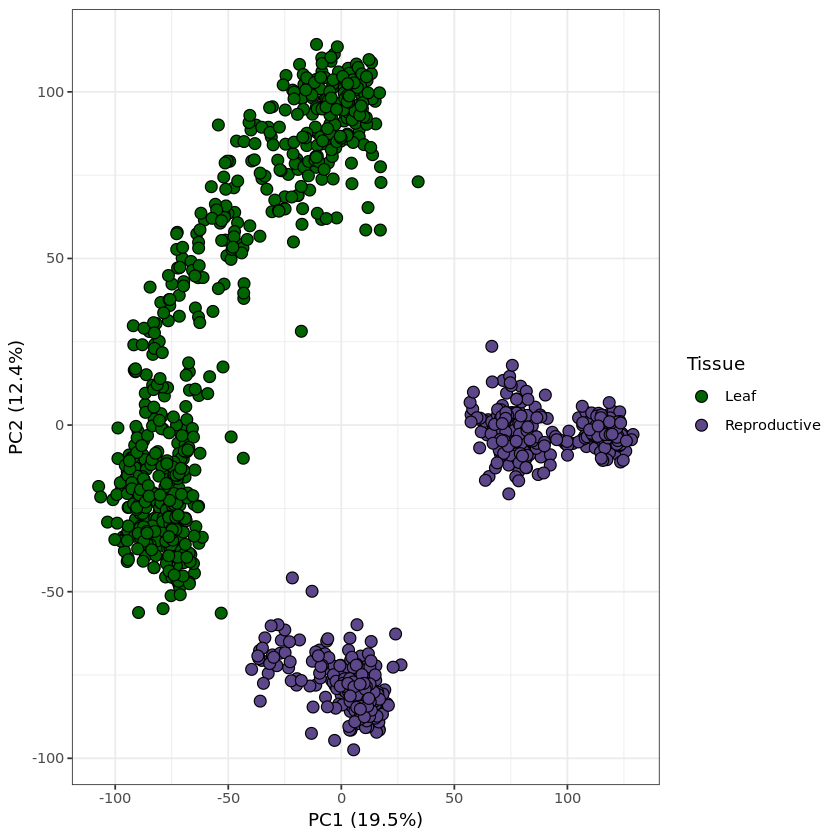

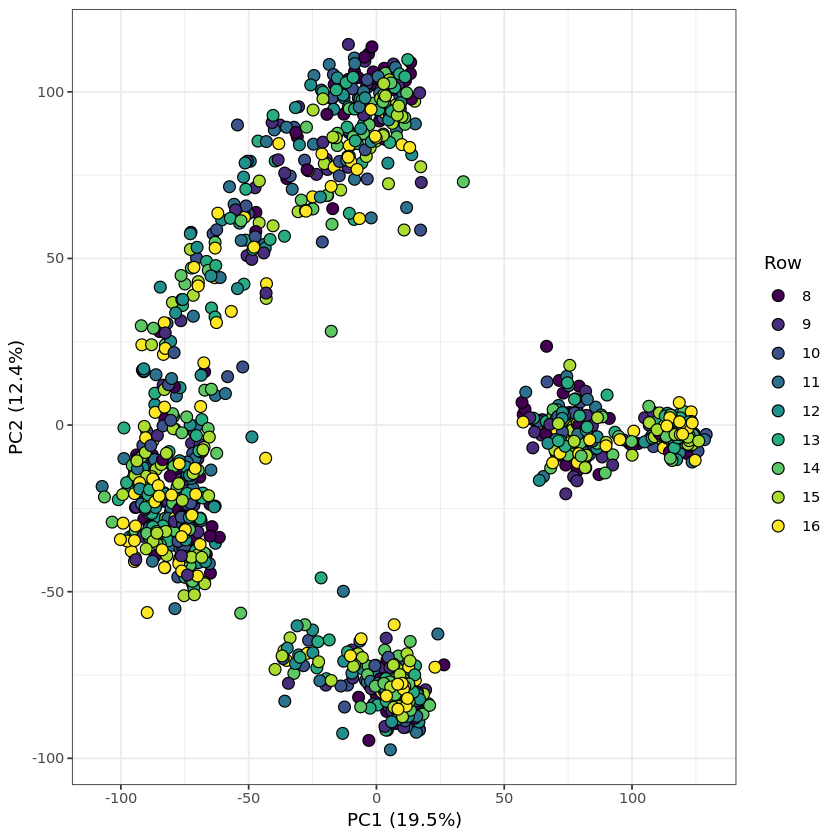

In [29]:
k <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Phenology, shape=Phenology)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  scale_fill_manual(values=p_palette) + 
  xlab("PC1 (19.5%)") + ylab("PC2 (12.4%)") +
  theme_bw()

l <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Year, shape=Year)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21)) + 
  scale_fill_manual(values=y_palette) + 
  xlab("PC1 (19.5%)") + ylab("PC2 (12.4%)") +
  theme_bw()

m <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) + 
  scale_fill_manual(values=rs_palette) + 
  xlab("PC1 (19.5%)") + ylab("PC2 (12.4%)") +
  theme_bw()

n <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Tissue, shape=Tissue)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 2)) + 
  scale_fill_manual(values=t_palette) + 
  xlab("PC1 (19.5%)") + ylab("PC2 (12.4%)") +
  theme_bw()

o <- ggplot(for_plot, aes(x=PC1, y=PC2, fill=Row, shape=Row)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=r_palette) + 
  xlab("PC1 (19.5%)") + ylab("PC2 (12.4%)") +
  theme_bw()

pdf("1718_geneExpression_PCA_45-55percentileVar.pdf", width=22, height=4)
  ggpubr::ggarrange(k, l, m, n, o, ncol=5)
dev.off()
k
l
m
n
o

## Is an irrigation effect present?
In order to assess whether or not to include irrigation in the model, I fit an LDA to all genes with sd>0 to try to parse variation attributable to the irrigation treatment. If model performs better then chance (Acc > NIR) on withheld data, irrigation will be included as an interacting term in the model. If not, it will just be a single fixed effect. 

In [30]:
## some genes are not variable within groups, which makes LDA sad. 
## So we are going to cut off the bottom 5%iles of genes.

geneVar <- apply(vsd_counts_varFilt, 2, sd)
quants <- quantile(geneVar, probs=seq(0, 1, 0.01))

cutoffLow <- as.double(quants['5%'])

geneVar_filt = rep(FALSE, length(geneVar))
geneVar_filt[geneVar > cutoffLow] <- TRUE
sum(geneVar_filt)

d <- vsd_counts_varFilt[,geneVar_filt]
dim(d)

[1] 23172

[1]  1178 23172

In [31]:
idx <- 1:dim(vsd_counts_varFilt)[1]
train_idx <- sort(sample(idx, size=ceiling(length(idx)*0.8), replace=F))
test_idx <- sort(idx[!(idx %in% train_idx)])

d$sampleName <- rownames(d)
d <- merge(d, (treatments %>% select(sampleName, Irrigation)), on='sampleName')

X_train <- d[train_idx,]
X_test <- d[test_idx,]
y_train <- X_train$Irrigation
y_test <- X_test$Irrigation

X_train$sampleName <- NULL
X_test$sampleName <- NULL
X_train$Irrigation <- NULL
X_test$Irrigation <- NULL

In [17]:
# dim(X_train)
# dim(X_test)

# table(y_train)
# table(y_test)

In [32]:
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

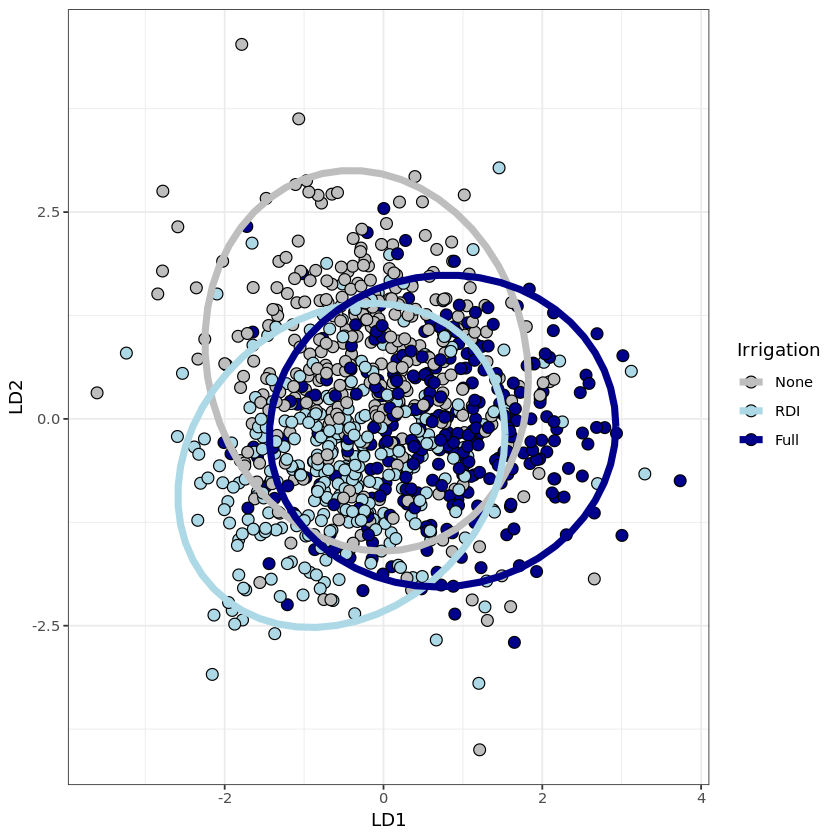

In [33]:
d <- as.data.frame(lda_plot$x)
d$Irrigation <- y_train

ggplot(d, aes(x=LD1, y=LD2, fill=Irrigation, shape=Irrigation)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 3)) + 
  scale_fill_manual(values=i_palette) + 
  stat_ellipse(aes(color=Irrigation), lwd=2) + 
  scale_color_manual(values=i_palette) + 
  theme_bw()

In [34]:
pred <- predict(lda, X_test)

Warning message:
“Removed 156 rows containing missing values (geom_path).”

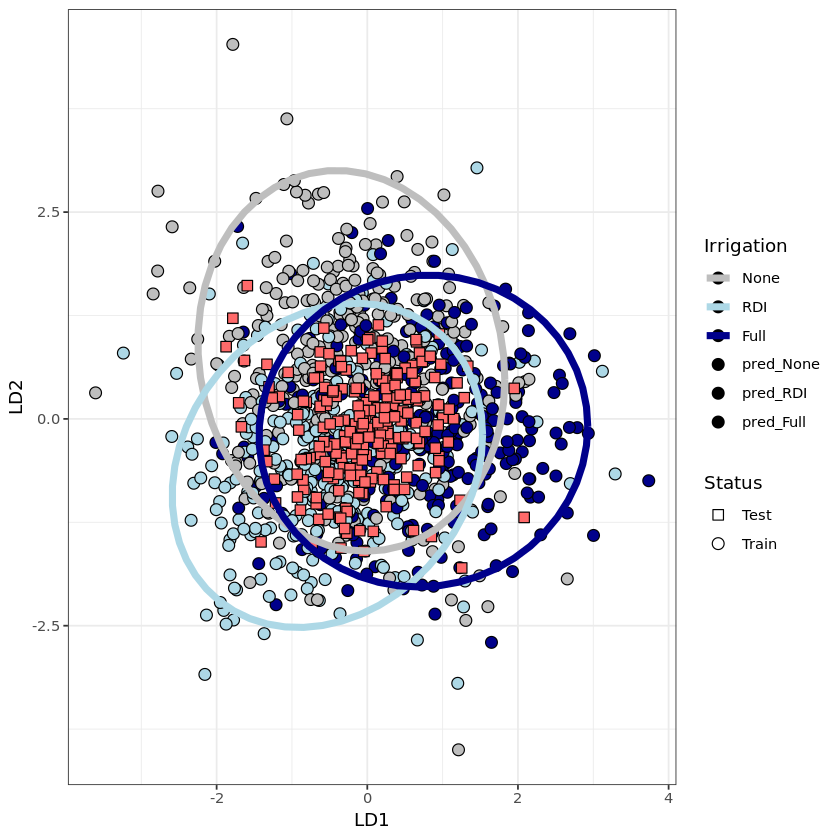

In [35]:
d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Irrigation <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Irrigation <- factor(d_pred$Irrigation, levels=c('None', 'RDI', 'Full', 'pred_None', 'pred_RDI', 'pred_Full'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

ggplot(d_pred, aes(x=LD1, y=LD2, fill=Irrigation, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(i_palette, 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Irrigation), lwd=2) + 
  scale_color_manual(values=c(i_palette, NA, NA, NA)) + 
  theme_bw()

In [36]:
caret::confusionMatrix(y_test, pred$class)

Confusion Matrix and Statistics

          Reference
Prediction None RDI Full
      None   29  28   17
      RDI    28  35   28
      Full   18  24   28

Overall Statistics
                                          
               Accuracy : 0.3915          
                 95% CI : (0.3287, 0.4571)
    No Information Rate : 0.3702          
    P-Value [Acc > NIR] : 0.2704          
                                          
                  Kappa : 0.083           
                                          
 Mcnemar's Test P-Value : 0.9531          

Statistics by Class:

                     Class: None Class: RDI Class: Full
Sensitivity               0.3867     0.4023      0.3836
Specificity               0.7188     0.6216      0.7407
Pos Pred Value            0.3919     0.3846      0.4000
Neg Pred Value            0.7143     0.6389      0.7273
Prevalence                0.3191     0.3702      0.3106
Detection Rate            0.1234     0.1489      0.1191
Detection Prevalence     

## How should time of day be included?

### Row?

In [37]:
d <- vsd_counts_varFilt[,geneVar_filt]
dim(d)

d$sampleName <- rownames(d)
d <- merge(d, (treatments %>% select(sampleName, Row)), on='sampleName')

X_train <- d[train_idx,]
X_test <- d[test_idx,]
y_train <- X_train$Row
y_test <- X_test$Row

X_train$sampleName <- NULL
X_test$sampleName <- NULL
X_train$Row <- NULL
X_test$Row <- NULL

[1]  1178 23172

In [38]:
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Row <- y_train

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

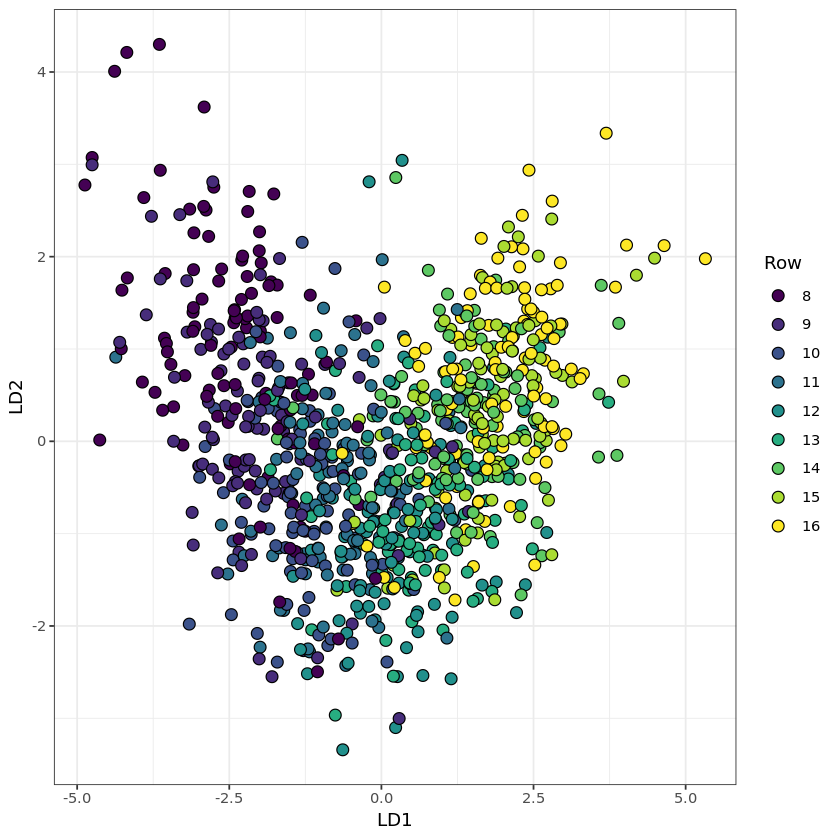

In [39]:
ggplot(d, aes(x=LD1, y=LD2, fill=Row, shape=Row)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=r_palette) + 
  #stat_ellipse(aes(color=Row), lwd=2) + 
  #scale_color_manual(values=r_palette) + 
  theme_bw()

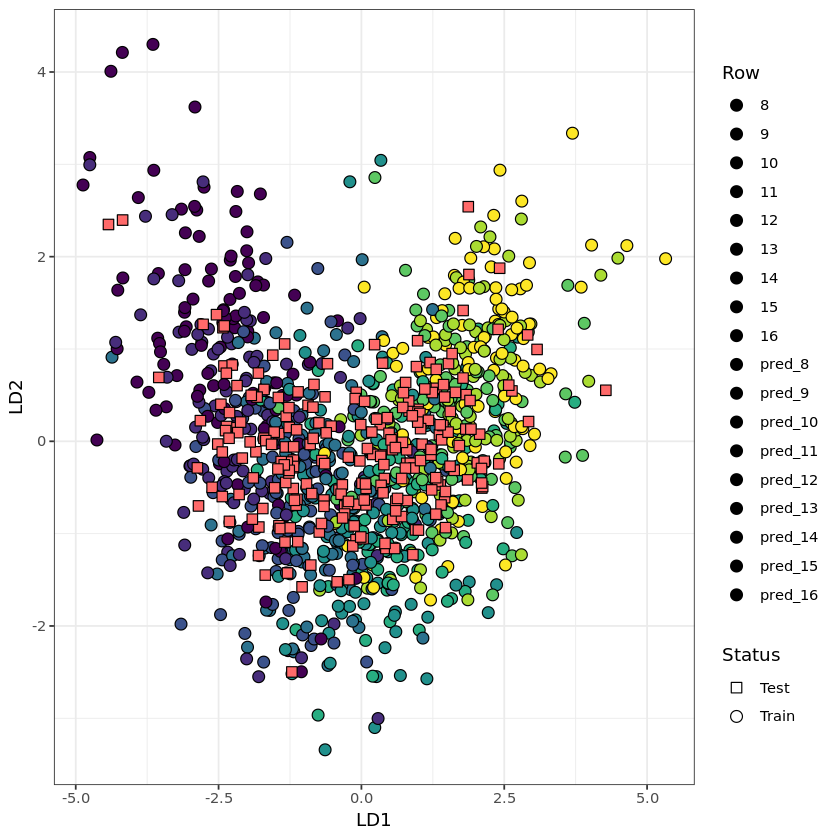

In [40]:
pred <- predict(lda, X_test)
d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Row <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Row <- factor(d_pred$Row, levels=c(8:16, paste('pred_', 8:16, sep='')))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

ggplot(d_pred, aes(x=LD1, y=LD2, fill=Row, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(r_palette, rep('indianred1', 9))) + 
  #stat_ellipse(aes(color=Row), lwd=2) + 
  #scale_color_manual(values=c(r_palette, rep(NA, 9))) + 
  theme_bw()

In [41]:
caret::confusionMatrix(y_test, pred$class)

Confusion Matrix and Statistics

          Reference
Prediction  8  9 10 11 12 13 14 15 16
        8  13  5  7  1  0  0  0  0  0
        9   6 10  7  4  1  0  0  0  0
        10  1 10  3  2  2  0  0  0  0
        11  1  3  9  8  8  4  0  0  1
        12  2  0  4  3  8  5  3  2  1
        13  0  1  4  4  6  6  3  2  1
        14  0  0  0  1  4  6  4  5  9
        15  0  0  1  1  1  2  6  5  5
        16  0  0  0  0  1  1  4  8 10

Overall Statistics
                                          
               Accuracy : 0.2851          
                 95% CI : (0.2283, 0.3474)
    No Information Rate : 0.1489          
    P-Value [Acc > NIR] : 6.729e-08       
                                          
                  Kappa : 0.197           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 8 Class: 9 Class: 10 Class: 11 Class: 12 Class: 13
Sensitivity           0.56522  0.34483   0.08571   0.33333

### Block

In [42]:
d <- vsd_counts_varFilt[,geneVar_filt]
dim(d)

d$sampleName <- rownames(d)
d <- merge(d, (treatments %>% select(sampleName, Block)), on='sampleName')

X_train <- d[train_idx,]
X_test <- d[test_idx,]
y_train <- X_train$Block
y_test <- X_test$Block

X_train$sampleName <- NULL
X_test$sampleName <- NULL
X_train$Block <- NULL
X_test$Block <- NULL

[1]  1178 23172

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

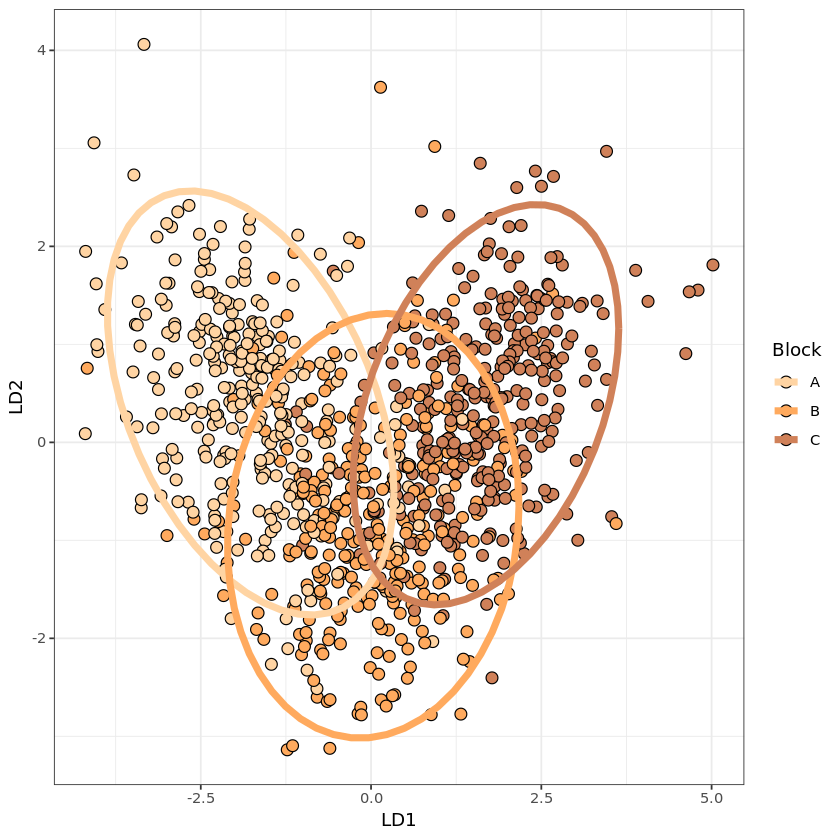

In [46]:
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Block <- y_train

ggplot(d, aes(x=LD1, y=LD2, fill=Block, shape=Block)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=b_palette) + 
  stat_ellipse(aes(color=Block), lwd=2) + 
  scale_color_manual(values=b_palette) + 
  theme_bw()

Warning message:
“Removed 156 rows containing missing values (geom_path).”

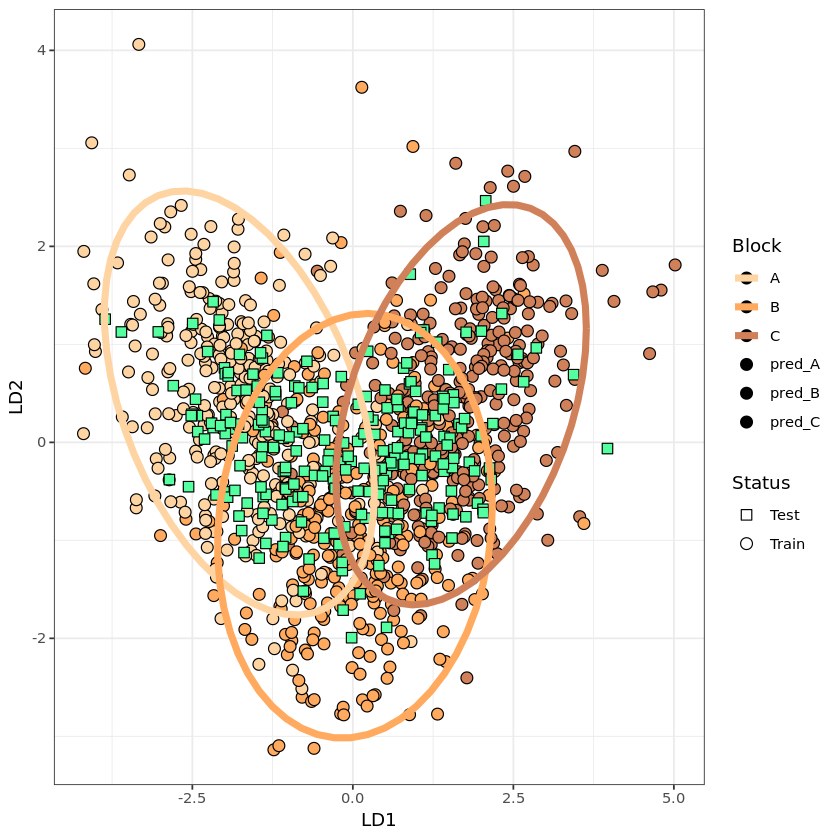

In [47]:
pred <- predict(lda, X_test)
d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Block <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Block <- factor(d_pred$Block, levels=c('A', 'B', 'C', paste('pred_', c('A', 'B', 'C'), sep='')))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

ggplot(d_pred, aes(x=LD1, y=LD2, fill=Block, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(b_palette, rep('seagreen1', 3))) + 
  stat_ellipse(aes(color=Block), lwd=2) + 
  scale_color_manual(values=c(b_palette, rep(NA, 3))) + 
  theme_bw()

In [48]:
caret::confusionMatrix(y_test, pred$class)

Confusion Matrix and Statistics

          Reference
Prediction  A  B  C
         A 63  9  0
         B 19 59 11
         C  0 14 60

Overall Statistics
                                          
               Accuracy : 0.7745          
                 95% CI : (0.7156, 0.8263)
    No Information Rate : 0.3489          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6613          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C
Sensitivity            0.7683   0.7195   0.8451
Specificity            0.9412   0.8039   0.9146
Pos Pred Value         0.8750   0.6629   0.8108
Neg Pred Value         0.8834   0.8425   0.9317
Prevalence             0.3489   0.3489   0.3021
Detection Rate         0.2681   0.2511   0.2553
Detection Prevalence   0.3064   0.3787   0.3149
Balanced Accuracy      0.8547   0.7617   0.8799

## Fitting Linear Models to All Genes

From the above, it looks like Irrigation is still not a reliable treatment for the 2017/2018 reproductive samples. But, there is still a clear signal from time. However, it is *as* reliable at the row level, so we can use block. Below, I fit the following model to each gene: gene ~ Irrigation + Year\*Phenology\*Rootstock\*Block. From each model, I store the SS from each model term (including the residuals) and the p-value associated with that model term. There is then a function to extract the p-values, correct them under an FDR model, and summarize the outputs. These can then be mined for interesting results. 

In [49]:
options(contrasts=c("contr.sum", "contr.poly"))

In [172]:
## For benchmarking to extract a few genes at a time
# x <- colMeans(vsd_counts_varFilt)
# y <- apply(vsd_counts_varFilt, 2, sd)
# vsd_counts_model <- vsd_counts_varFilt[x > 9 & y > as.double(quantile(y, probs=0.9))]
# dim(vsd_counts_model)

[1] 1178  118

In [173]:
#merge metadata
vsd_counts_model <- vsd_counts_varFilt
vsd_counts_model$sampleName <- rownames(vsd_counts_model)
vsd_counts_model <- merge(vsd_counts_model, treatments, on='sampleName')

In [174]:
#head(vsd_counts_model)
dim(vsd_counts_model)
colnames(vsd_counts_model)[2]

[1]  1178 24402

[1] "Vitvi00g00444"

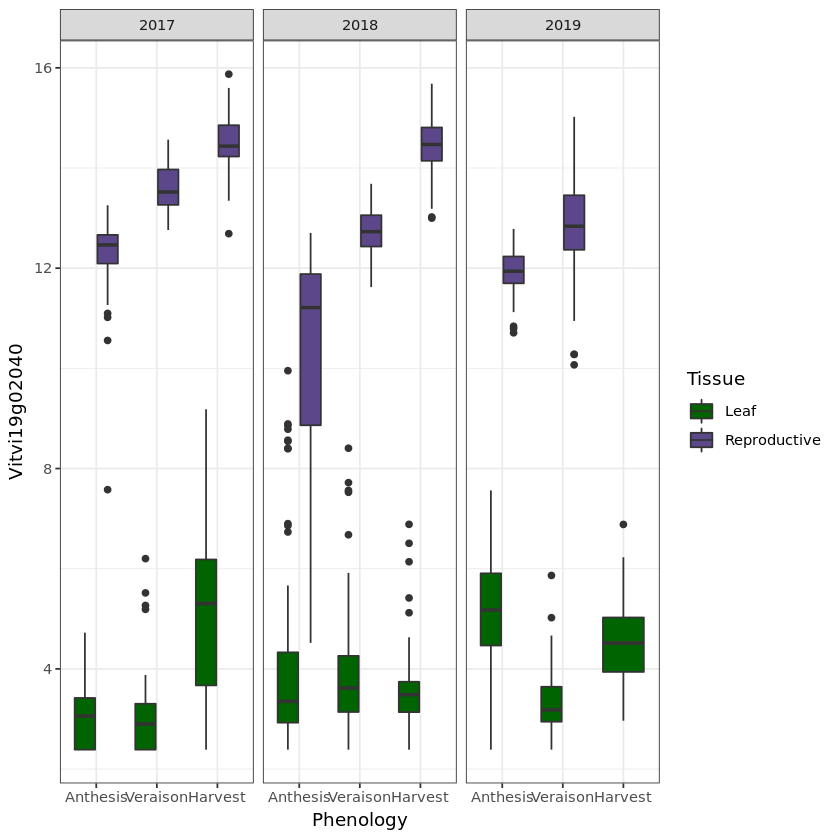

In [52]:
ggplot(vsd_counts_model, aes(x=Phenology, y=Vitvi19g02040, fill=Tissue)) + 
  geom_boxplot() +
  facet_wrap('Year') + 
  scale_fill_manual(values=t_palette) + 
  theme_bw()

In [175]:
#First, I want to create some dummy models to get some factor name information

oldw <- getOption("warn")
options(warn = -1)

vsd_counts_model <- vsd_counts_model[!(vsd_counts_model$Year == '2019' & vsd_counts_model$Phenology == 'Harvest'),]
dim(vsd_counts_model)
lmod <- lm(Vitvi00g00444 ~ Irrigation + Year + Phenology + Rootstock + Block + Tissue + Year*Phenology + Year*Rootstock + Year*Block + Year*Tissue + Phenology*Rootstock + Phenology*Block + Phenology*Tissue + Rootstock*Block + Rootstock*Tissue + Block*Tissue, data=vsd_counts_model) #+ Year*Phenology*Rootstock + Year*Phenology*Block + Year*Phenology/Tissue + Year*Rootstock*Block + Year*Rootstock/Tissue + Year*Block/Tissue + Phenology*Rootstock/Tissue + Phenology*Block/Tissue + Rootstock*Block/Tissue, data=vsd_counts_model)

options(warn = oldw)

[1]  1107 24402

In [176]:
# create dummy anova
lmAn <- car::Anova(lmod, type=2, singular.ok=T)
#lmAn <- anova(lmod)

Note: model has aliased coefficients
      sums of squares computed by model comparison


In [177]:
lmAn#[lmAn$Pr < 0.05,]
as.data.frame(pairs(emmeans::emmeans(lmod, ~Phenology:Tissue)))

Sum Sq       Df   F value    Pr(>F)      
Irrigation            0.05770267    2  0.1189803 8.878372e-01
Year                 22.20889275    2 45.7937459 8.465317e-20
Phenology            22.99609736    2 47.4169267 1.904938e-20
Rootstock             0.89274494    3  1.2272002 2.985286e-01
Block                 0.87190939    2  1.7978383 1.661633e-01
Tissue               12.70769229    1 52.4053890 8.678175e-13
Year:Phenology        4.70811682    3  6.4719512 2.428719e-04
Year:Rootstock        2.81556874    6  1.9351924 7.228821e-02
Year:Block            1.31882093    4  1.3596750 2.459627e-01
Year:Tissue           1.27144170    2  2.6216560 7.315543e-02
Phenology:Rootstock   2.52427546    6  1.7349811 1.095910e-01
Phenology:Block       2.51706374    4  2.5950366 3.508510e-02
Phenology:Tissue      3.86977460    2  7.9793026 3.635440e-04
Rootstock:Block       0.68576703    6  0.4713403 8.299091e-01
Rootstock:Tissue      0.44546645    3  0.6123546 6.070598e-01
Block:Tissue          0.46807100    2  0.9651415 3.812650e-01
Residuals           256.06761649 1056         NA           NA

contrast                                      estimate    SE         df  
1  Anthesis,Leaf - Veraison,Leaf                  0.14961281 0.04884927 1056
2  Anthesis,Leaf - Harvest,Leaf                           NA         NA   NA
3  Anthesis,Leaf - Anthesis,Reproductive          0.10071109 0.04852453 1056
4  Anthesis,Leaf - Veraison,Reproductive          0.52321926 0.04891622 1056
5  Anthesis,Leaf - Harvest,Reproductive                   NA         NA   NA
6  Veraison,Leaf - Harvest,Leaf                           NA         NA   NA
7  Veraison,Leaf - Anthesis,Reproductive         -0.04890172 0.04841428 1056
8  Veraison,Leaf - Veraison,Reproductive          0.37360645 0.04878937 1056
9  Veraison,Leaf - Harvest,Reproductive                   NA         NA   NA
10 Harvest,Leaf - Anthesis,Reproductive                   NA         NA   NA
11 Harvest,Leaf - Veraison,Reproductive                   NA         NA   NA
12 Harvest,Leaf - Harvest,Reproductive            0.20392037 0.06331034 1056
13 Anthesis,Reproductive - Veraison,Reproductive  0.42250816 0.04846880 1056
14 Anthesis,Reproductive - Harvest,Reproductive           NA         NA   NA
15 Veraison,Reproductive - Harvest,Reproductive           NA         NA   NA
   t.ratio   p.value     
1   3.062744 2.721976e-02
2         NA           NA
3   2.075468 3.009656e-01
4  10.696232 0.000000e+00
5         NA           NA
6         NA           NA
7  -1.010068 9.146723e-01
8   7.657538 5.841994e-13
9         NA           NA
10        NA           NA
11        NA           NA
12  3.220965 1.655672e-02
13  8.717117 0.000000e+00
14        NA           NA
15        NA           NA

In [178]:
# generate column names for the master matrix
lmAn_c1 <- paste(rownames(lmAn), 'ss', sep='_')
lmAn_c2 <- paste(rownames(lmAn), 'p', sep='_')
lmAn_colnames <- c(lmAn_c1, lmAn_c2)
lmAn_colnames <- lmAn_colnames[-length(lmAn_colnames)]

print(lmAn_colnames)

 [1] "Irrigation_ss"          "Year_ss"                "Phenology_ss"          
 [4] "Rootstock_ss"           "Block_ss"               "Tissue_ss"             
 [7] "Year:Phenology_ss"      "Year:Rootstock_ss"      "Year:Block_ss"         
[10] "Year:Tissue_ss"         "Phenology:Rootstock_ss" "Phenology:Block_ss"    
[13] "Phenology:Tissue_ss"    "Rootstock:Block_ss"     "Rootstock:Tissue_ss"   
[16] "Block:Tissue_ss"        "Residuals_ss"           "Irrigation_p"          
[19] "Year_p"                 "Phenology_p"            "Rootstock_p"           
[22] "Block_p"                "Tissue_p"               "Year:Phenology_p"      
[25] "Year:Rootstock_p"       "Year:Block_p"           "Year:Tissue_p"         
[28] "Phenology:Rootstock_p"  "Phenology:Block_p"      "Phenology:Tissue_p"    
[31] "Rootstock:Block_p"      "Rootstock:Tissue_p"     "Block:Tissue_p"        


In [179]:
oldw <- getOption("warn")
options(warn = -1)

genes <- colnames(vsd_counts_model)[!colnames(vsd_counts_model) %in% colnames(treatments)]
fit_genes <- c()
isAliased <- c()

# gene names need to be stored away from models to prevent unwanted type conversions
lm_out <- matrix(ncol=length(lmAn_colnames))
COUNTER <- 0

# store gene, models, data
stored_models <- list()

for (gene in genes) {

    d <- vsd_counts_model %>% select(gene, Year:Block)
    colnames(d) <- c('gene', 'Year', 'Tissue', 'Phenology', 'indexer', 'Rootstock', 'Irrigation', 'Row', 'Block')
    d <- d[d$Year != '2019' & d$Phenology != 'Harvest' ,]

    if (sd(d$gene) > 0){   
        #standardize
        d$gene <- scale(d$gene, scale=T, center=T)[,1]
    
        #remove anomalies
        d <- anomalize(as_tibble(d), target='gene', alpha=0.03, max_anoms=0.1)
        d <- d[d$anomaly == 'No',]
        
        if (sd(d$gene > 0)){

            #lm + aliases coefficient check
            lmod <- lm(gene ~ Irrigation + Year + Phenology + Rootstock + Block + Tissue + Year*Phenology + Year*Rootstock + Year*Block + Year*Tissue + Phenology*Rootstock + Phenology*Block + Phenology*Tissue + Rootstock*Block + Rootstock*Tissue + Block*Tissue, data=d)
            if (sum(summary(lmod)$aliased) > 0) {
                isAliased <- c(isAliased, 'yes')
            } else {
                isAliased <- c(isAliased, 'no')
            }
            #anova + extractions
            lmAn <- car::Anova(lmod, type=2, singular.ok=T)
            #lmAn <- anova(lmod)
            lm_out_tmp <- c(lmAn$Sum, lmAn$Pr)
            #remove residual p (last item)
            lm_out_tmp <- lm_out_tmp[-length(lm_out_tmp)]
            lm_out <- rbind(lm_out, lm_out_tmp)
            fit_genes <- c(fit_genes, gene)

            #store important things
            stored_models[[gene]] <- list(data=d, model=lmod)
        }
        
    }
   
    if (COUNTER %% 1000 == 0){
        print(sprintf("%d genes fit", COUNTER))
        flush.console()
    }
    
    COUNTER <- COUNTER + 1
}

lm_out <- as.data.frame(lm_out[2:dim(lm_out)[1],])
colnames(lm_out) <- lmAn_colnames
lm_out$gene <- fit_genes
lm_out$isAliased <- isAliased

options(warn = oldw)

[1] "0 genes fit"
[1] "1000 genes fit"
[1] "2000 genes fit"
[1] "3000 genes fit"
[1] "4000 genes fit"
[1] "5000 genes fit"
[1] "6000 genes fit"
[1] "7000 genes fit"
[1] "8000 genes fit"
[1] "9000 genes fit"
[1] "10000 genes fit"
[1] "11000 genes fit"
[1] "12000 genes fit"
[1] "13000 genes fit"
[1] "14000 genes fit"
[1] "15000 genes fit"
[1] "16000 genes fit"
[1] "17000 genes fit"
[1] "18000 genes fit"
[1] "19000 genes fit"
[1] "20000 genes fit"
[1] "21000 genes fit"
[1] "22000 genes fit"
[1] "23000 genes fit"
[1] "24000 genes fit"


In [196]:
write.csv(lm_out, file='1719_geneExpression_lm_out.csv', quote=F, row.names=F)

In [11]:
lm_out <- read.csv('1719_geneExpression_lm_out.csv')
colnames(lm_out) <- c('Irrigation_ss', 'Year_ss', 'Phenology_ss', 'Rootstock_ss', 'Block_ss', 'Tissue_ss',
                      'Year:Phenology_ss', 'Year:Rootstock_ss', 'Year:Block_ss', 'Year:Tissue_ss',
                      'Phenology:Rootstock_ss', 'Phenology:Block_ss', 'Phenology:Tissue_ss', 
                      'Rootstock:Block_ss', 'Rootstock:Tissue_ss', 'Block:Tissue_ss', 'Residuals_ss', 
                      'Irrigation_p', 'Year_p', 'Phenology_p', 'Rootstock_p', 'Block_p', 'Tissue_p', 
                      'Year:Phenology_p', 'Year:Rootstock_p', 'Year:Block_p', 'Year:Tissue_p', 
                      'Phenology:Rootstock_p', 'Phenology:Block_p', 'Phenology:Tissue_p', 
                      'Rootstock:Block_p', 'Rootstock:Tissue_p', 'Block:Tissue_p', 'gene', 'isAliased')

In [12]:
lm_out_padj <- lm_out %>% select(Irrigation_p:`Block:Tissue_p`) %>% apply(MARGIN=2, FUN=p.adjust, method='fdr') %>% as.data.frame()
lm_out_justp <- lm_out %>% select(Irrigation_p:`Block:Tissue_p`)

In [13]:
rownames(lm_out_padj) <- lm_out$gene
rownames(lm_out_justp) <- lm_out$gene

In [14]:
count_sigGenes <- function(p_vec, p_cutoff){
    check <- rep(FALSE, length(p_vec))
    check[p_vec < p_cutoff] <- TRUE
    return(sum(check))
}

extract_sigGenes <- function(p_vec, p_cutoff){
    check <- rep(FALSE, length(p_vec))
    check[p_vec < p_cutoff] <- TRUE
    return(lm_out$gene[check])
}

#apply(X=glm_out_padj, MARGIN=2, FUN=count_sigGenes, p_cutoff=0.05)
sigGenesCounts <- apply(X=lm_out_padj, MARGIN=2, FUN=count_sigGenes, p_cutoff=0.05)
sigGenesCounts

sigGenesCountsNoCorr <- apply(X=lm_out_justp, MARGIN=2, FUN=count_sigGenes, p_cutoff=0.05)
sigGenesCountsNoCorr

sigGenes <- apply(X=lm_out_padj, MARGIN=2, FUN=extract_sigGenes, p_cutoff=0.05)
#sigGenes

Irrigation_p                Year_p           Phenology_p 
                   19                 15955                 18671 
          Rootstock_p               Block_p              Tissue_p 
                    8                  8271                 19456 
     Year:Phenology_p      Year:Rootstock_p          Year:Block_p 
                12852                     0                  1535 
        Year:Tissue_p Phenology:Rootstock_p     Phenology:Block_p 
                10413                     0                  2190 
   Phenology:Tissue_p     Rootstock:Block_p    Rootstock:Tissue_p 
                17719                     1                     0 
       Block:Tissue_p 
                 5224

Irrigation_p                Year_p           Phenology_p 
                 2617                 16346                 18770 
          Rootstock_p               Block_p              Tissue_p 
                 1960                 10077                 19523 
     Year:Phenology_p      Year:Rootstock_p          Year:Block_p 
                13620                  2322                  5263 
        Year:Tissue_p Phenology:Rootstock_p     Phenology:Block_p 
                11707                   914                  5621 
   Phenology:Tissue_p     Rootstock:Block_p    Rootstock:Tissue_p 
                17902                   885                  1419 
       Block:Tissue_p 
                 7799

### Percent Variation Explained as Interable Term

In [15]:
SS <- lm_out %>% select(`Irrigation_ss`:`Residuals_ss`)
SS$Sum <- rowSums(SS)

eta2 <- matrix(nrow=dim(SS)[1])

for (col in colnames(SS)){
    eta2 <- cbind(eta2, SS[,col] / SS$Sum * 100)
}

df <- as.data.frame(eta2)
colnames(df) <- c('NA', colnames(SS))
df$`NA` <- NULL
df$Sum <- NULL

rownames(df) <- lm_out$gene
df_sub <- df[rowSums(df) > 10,]
df_sub

df_sub$gene <- rownames(df_sub)

Irrigation_ss Year_ss      Phenology_ss Rootstock_ss Block_ss   
Vitvi00g00444 0.137870787   2.438453e-01  9.74127059  0.66611900   0.730560750
Vitvi00g00447 0.277127197   3.284956e+00  0.06845418  0.16303191   0.003767245
Vitvi00g00547 0.471787062   1.228883e+00  0.27528500  1.60833081   0.052465783
Vitvi00g00610 0.074782894   2.328560e-01  3.93709711  0.31171863   0.428557621
Vitvi00g00612 0.041965593   2.759159e+00  3.38368195  0.36452784   0.488677582
Vitvi00g00614 0.007566025   2.008247e+00  1.69592703  0.33730995   0.454698012
Vitvi00g00615 0.068638620   2.379052e-01  5.81619785  0.11510360   0.672870665
Vitvi00g00616 0.041244409   2.876663e-01 25.78715706  0.08152777   0.126885051
Vitvi00g00667 0.693958432   1.314099e+00  2.68175667  0.27498498   0.341138593
Vitvi00g00670 0.009803457   3.667056e-01  6.80386791  0.16478270   0.318927751
Vitvi00g00671 0.014907024   1.744346e-01  4.30153015  0.12939978   0.640820345
Vitvi00g00672 0.030610780   4.033356e+00  2.62368068  0.21288256   0.257483187
Vitvi00g00673 0.356365438   7.212886e-01  6.51041883  0.10539014   0.221557586
Vitvi00g00674 0.175408619   1.431638e-04 15.54672765  0.13585420   0.568637647
Vitvi00g00675 0.062585712   1.387722e+00 20.59377222  0.49241084   0.339466497
Vitvi00g00676 0.811986819   1.858332e+01  0.83246487  0.75713400   0.467430259
Vitvi00g00711 0.061530872   2.970628e+00  3.16858510  0.70143047   0.246703329
Vitvi00g00786 0.345410588   1.273897e-03  5.13285788  0.20774550   0.339010264
Vitvi00g00789 0.939641794   2.806976e-01  0.76678475  0.47185041   0.346048864
Vitvi00g00790 0.007019634   7.338621e+00  0.89531631  0.18968737   0.364363322
Vitvi00g00792 0.122208614   2.445139e+00 35.01378730  0.85445483   3.518505382
Vitvi00g00794 0.369800349   5.053365e-01 45.49675582  0.17210071   0.151820155
Vitvi00g00795 0.810691703   1.260369e-02  0.10521441  0.64107665   1.423140434
Vitvi00g00813 0.106903258   1.352366e-01  0.17241578  0.67777796   0.172534629
Vitvi00g00814 0.338449374   8.469461e+00 17.55729931  0.29438935   2.170387062
Vitvi00g00816 0.349046092   1.078252e+01  1.30461870  0.17405590   2.458150180
Vitvi00g00817 0.528247041   1.293771e+00  1.44231264  0.06015749   0.886223729
Vitvi00g00822 0.139366317   6.988892e-01  0.75402616  0.61897013   0.030995471
Vitvi00g00824 0.002118584   8.130212e+00 16.07081218  0.10700608   0.345952320
Vitvi00g00859 0.467394222   3.806818e+00  4.43874149  0.37073702   1.715288679
⋮             ⋮             ⋮            ⋮            ⋮            ⋮          
Vitvi19g02269 0.1191073163  6.344186e+00 1.864735e+00 0.41181040   0.17446165 
Vitvi19g02272 0.0763253868  1.101108e+00 1.942789e-02 1.89764771   0.37983220 
Vitvi19g02273 0.0788651101  1.820241e+00 1.931000e-01 0.94919222   0.82095160 
Vitvi19g02274 0.5797061590  1.201751e+00 1.935003e+00 0.62178776   0.17511426 
Vitvi19g02278 0.9200935489  4.830434e-01 3.594565e-01 0.46644693   0.94464956 
Vitvi19g02282 0.0607481426  2.266674e+00 3.758712e+01 0.15744754   0.09566163 
Vitvi19g02286 0.0832494606  9.730265e-02 5.888833e+01 0.04699765   0.48117844 
Vitvi19g02287 0.2072199538  8.787702e-02 1.746022e+01 0.10921397   0.04264162 
Vitvi19g02290 0.0925998101  5.083526e+00 7.846811e-02 1.29811623   0.59859608 
Vitvi19g02291 0.3248647008  1.082308e+00 3.575563e-01 0.67065746   2.41799864 
Vitvi19g02292 0.0767913808  1.950013e+00 4.432970e-01 0.19398769   0.13439729 
Vitvi19g02299 0.0629539287  9.023456e+00 4.586523e-01 0.05767460   0.51740051 
Vitvi19g02303 0.0009523919  2.413979e+00 1.553679e+00 0.63685910   0.04721429 
Vitvi19g02308 0.2149024974  3.956939e+00 8.216165e-01 0.55478460   0.21928150 
Vitvi19g02321 0.1036635022  1.668181e+00 2.063324e+01 0.12669455   0.20722283 
Vitvi19g02322 0.0010575375  4.255093e+00 3.774368e+01 0.19055908   0.13589492 
Vitvi19g02323 0.0425546843  1.294476e-01 3.296785e+01 0.24653772   0.36401691 
Vitvi19g02330 1.3820186443  1.408395e-01 6.782713e-01 0.13164319   1.16788398 
Vitvi19g02331 0.5775610590  3.094141e-04 2.143294e-03 0.40678080

In [19]:
levels(as.factor(df_plot$factor))

[1] "I"     "Y"     "P"     "R"     "B"     "T"     "YP"    "YR"    "PR"   
[10] "YB"    "PB"    "RB"    "YT"    "PT"    "RT"    "BT"    "YPR"   "YPB"  
[19] "YRB"   "PRB"   "YPT"   "YRT"   "PRT"   "YBT"   "PBT"   "RBT"   "YPRB" 
[28] "YPRT"  "YPBT"  "YRBT"  "PRBT"  "YPRBT" "Res"

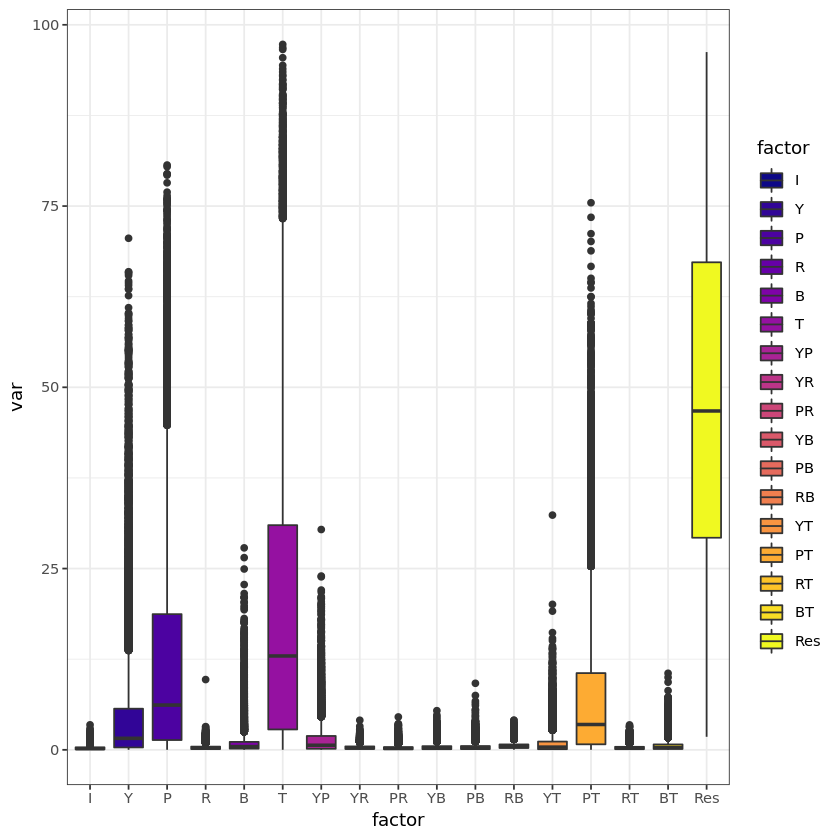

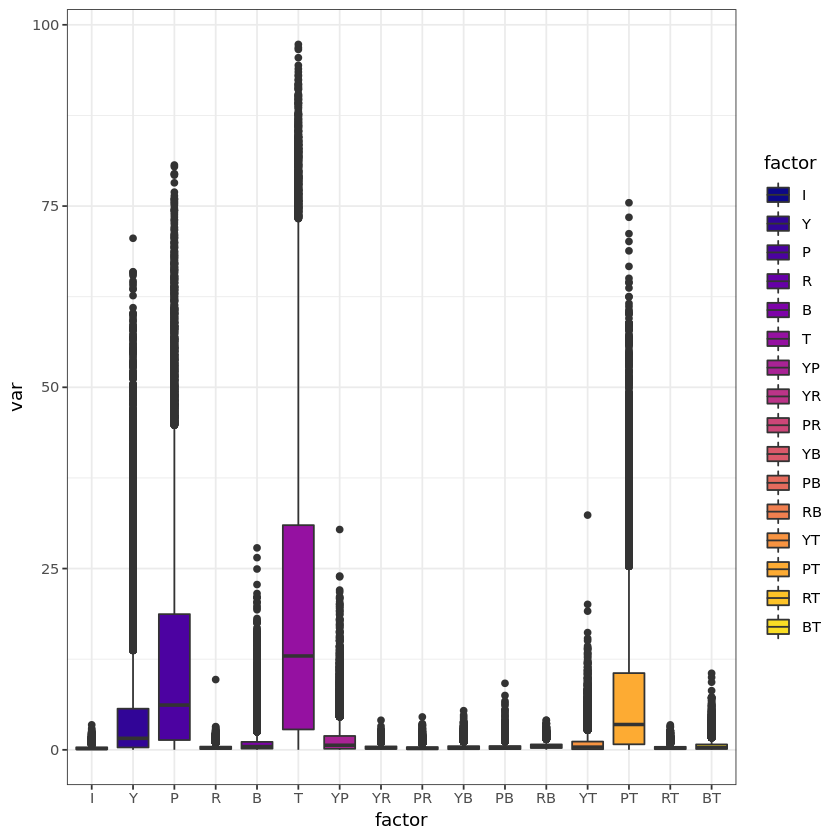

In [23]:
df_plot <- df_sub %>% tidyr::gather(factor, var, Irrigation_ss:Residuals_ss)
df_plot$factor <- factor(df_plot$factor, levels=c('Irrigation_ss','Year_ss','Phenology_ss',
                         'Rootstock_ss','Block_ss','Tissue_ss',
                         'Year:Phenology_ss','Year:Rootstock_ss',
                         'Phenology:Rootstock_ss','Year:Block_ss',
                         'Phenology:Block_ss','Rootstock:Block_ss',
                         'Year:Tissue_ss','Phenology:Tissue_ss',
                         'Rootstock:Tissue_ss','Block:Tissue_ss', 'Residuals_ss'),
#                          'Year:Phenology:Rootstock_ss','Year:Phenology:Block_ss',
#                          'Year:Rootstock:Block_ss','Phenology:Rootstock:Block_ss',
#                          'Year:Phenology:Tissue_ss','Year:Rootstock:Tissue_ss',
#                          'Phenology:Rootstock:Tissue_ss','Year:Block:Tissue_ss',
#                          'Phenology:Block:Tissue_ss','Rootstock:Block:Tissue_ss',
#                          'Year:Phenology:Rootstock:Block_ss','Year:Phenology:Rootstock:Tissue_ss',
#                          'Year:Phenology:Block:Tissue_ss','Year:Rootstock:Block:Tissue_ss',
#                          'Phenology:Rootstock:Block:Tissue_ss','Year:Phenology:Rootstock:Block:Tissue_ss','Residuals_ss'), 
                         labels=c('I','Y','P','R','B','T','YP','YR','PR','YB','PB','RB','YT','PT','RT','BT', 'Res'))
#                                   'YPR','YPB','YRB','PRB','YPT','YRT','PRT','YBT','PBT','RBT',
#                                   'YPRB','YPRT','YPBT','YRBT','PRBT','YPRBT', 'Res'))


#pdf('1718_BerryGeneExpression_factorVarDist.pdf', width=18, height=6)
ggplot(df_plot, aes(x=factor, y=var, fill=factor)) + 
  geom_boxplot() + 
  scale_fill_manual(values=viridisLite::plasma(17)) + 
  theme(axis.text.x=element_text(angle=90, hjust=1)) + 
  theme_bw()
#dev.off()

df_noRes <- df_plot[df_plot$factor != 'Res',]
ggplot(df_noRes, aes(x=factor, y=var, fill=factor)) + 
  geom_boxplot() + 
  scale_fill_manual(values=viridisLite::plasma(17)) + 
  theme(axis.text.x=element_text(angle=90, hjust=1)) + 
  theme_bw()

In [30]:
df_plot %>% group_by(factor) %>% summarise(q0=quantile(var, 0), q25=quantile(var, 0.25), q50=quantile(var, 0.5), 
                                           q75=quantile(var, 0.75), q100=quantile(var, 1.0), mean=mean(var), sd=sd(var))

factor                 q0           q25         q50        q75       
1  Block_ss               1.281894e-07  0.16286218  0.4448152  1.0920616
2  Block:Tissue_ss        5.500464e-06  0.11725235  0.3164697  0.7408247
3  Irrigation_ss          3.849998e-05  0.06726627  0.1655456  0.3420946
4  Phenology_ss           6.457564e-08  1.34676987  6.1727981 18.7143623
5  Phenology:Block_ss     5.380276e-05  0.10103516  0.2434415  0.5194596
6  Phenology:Rootstock_ss 1.817830e-04  0.08326499  0.1877331  0.3714031
7  Phenology:Tissue_ss    2.829986e-10  0.75907471  3.4891865 10.5789621
8  Residuals_ss           1.793183e+00 29.25086774 46.7383349 67.2455034
9  Rootstock_ss           1.452200e-04  0.10616961  0.2281845  0.4426732
10 Rootstock:Block_ss     6.213949e-03  0.25197972  0.4402873  0.7403108
11 Rootstock:Tissue_ss    5.895502e-05  0.09798723  0.2145598  0.4133906
12 Tissue_ss              3.954861e-07  2.81078094 12.9425392 30.9845040
13 Year_ss                2.111906e-09  0.32374909  1.5816577  5.6687325
14 Year:Block_ss          2.073130e-05  0.09050342  0.2326457  0.5044309
15 Year:Phenology_ss      1.539708e-10  0.14031503  0.6299279  1.9072530
16 Year:Rootstock_ss      3.636982e-04  0.11726777  0.2550000  0.4687666
17 Year:Tissue_ss         1.959771e-11  0.08450181  0.3769330  1.1340060
   q100      mean       sd        
1  27.853345  0.9668067  1.5951879
2  10.557511  0.5676363  0.7150483
3   3.445938  0.2536383  0.2736487
4  80.659992 12.1416858 14.2079419
5   9.174677  0.3927482  0.4579452
6   4.534083  0.2817498  0.3000096
7  75.456164  7.5142373  9.7060650
8  96.237518 48.5399393 23.3085189
9   9.689775  0.3270431  0.3227586
10  4.081548  0.5573291  0.4323622
11  3.438775  0.3077470  0.3054299
12 97.296945 20.0483170 20.8922993
13 70.558146  4.9630670  8.2338895
14  5.398790  0.3784255  0.4338247
15 30.385298  1.5002717  2.2304571
16  4.078399  0.3424040  0.3153337
17 32.373227  0.9169539  1.4330580

In [37]:
d <- df_plot[df_plot$factor == 'Rootstock_ss' & df_plot$var > 0.4426732,]
dim(d)

genes_for_SOM_PVE_rootstock <- d$gene
save(genes_for_SOM_PVE_rootstock, file="1719_genes_for_SOM_PVE_rootstock.Rdata")

[1] 5495    3

In [38]:
d <- df_plot[df_plot$factor == 'Phenology:Tissue_ss' & df_plot$var > 0.4426732,]
dim(d)

genes_for_SOM_PVE_phenologyTissue <- d$gene
save(genes_for_SOM_PVE_phenologyTissue, file="1719_genes_for_SOM_PVE_phenologyTissue.Rdata")

[1] 17738     3

In [49]:
for (f in unique(df_plot$factor)){
    d <- df_plot[df_plot$factor == f & df_plot$var > 0.4426732,]
    filename <- paste("1719_genes_for_SOM_PVE", f, sep="_")
    filename <- stringr::str_replace(filename, pattern='_ss', replacement = '')
    filename <- stringr::str_replace(filename, pattern=':', replacement = '')
    filename <- paste(filename, ".Rdata", sep='')
    genes_for_SOM <- d$gene
    save(genes_for_SOM, file=filename)
}

In [193]:
x <- intersect(intersect(sigGenes$`Year:Phenology_p`, sigGenes$`Year:Tissue_p`), sigGenes$`Phenology:Tissue_p`)
length(x)

[1] 5856

In [197]:
genes_for_SOM_PhenologyTissue <- sigGenes$`Phenology:Tissue_p`
save(genes_for_SOM_PhenologyTissue, file='1719_genes_for_SOM_PhenologyTissue.Rdata')

genes_for_SOM_YearPhenology <- sigGenes$`Year:Phenology_p`
save(genes_for_SOM_YearPhenology, file='1719_genes_for_SOM_YearPhenology.Rdata')

genes_for_SOM_YearTissue <- sigGenes$`Year:Tissue_p`
save(genes_for_SOM_YearTissue, file='1719_genes_for_SOM_YearTissue.Rdata')

In [198]:
sigGenesJustp <- apply(X=lm_out_justp, MARGIN=2, FUN=extract_sigGenes, p_cutoff=0.05)

In [199]:
genes_for_SOM_RootstockJustp <- sigGenesJustp$Rootstock_p
save(genes_for_SOM_RootstockJustp, file='1719_genes_for_SOM_RootstockJustp.Rdata')

In [202]:
genes_for_SOM_PhenologyRootstockJustp <- sigGenesJustp$`Phenology:Rootstock_p`
save(genes_for_SOM_PhenologyRootstockJustp, file='1719_genes_for_SOM_PhenologyRootstockJustp.Rdata')

In [200]:
genes_for_SOM_RootstockBlockJustp <- sigGenesJustp$`Rootstock:Block_p`
save(genes_for_SOM_RootstockBlockJustp, file='1719_genes_for_SOM_RootstockBlockJustp.Rdata')

In [201]:
genes_for_SOM_RootstockTissueJustp <- sigGenesJustp$`Rootstock:Tissue_p`
save(genes_for_SOM_RootstockTissueJustp, file='1719_genes_for_SOM_RootstockTissueJustp.Rdata')

In [68]:
g <- which(stored_models$gene == 'Vitvi00g01258')
a <- pairs(emmeans::emmeans(stored_models$model[[g]], as.formula("~Rootstock|Block"), data=stored_models$data[[g]]))
as.data.frame(a)

ERROR: Error in ref_grid(object, ...): Can't handle an object of class  “NULL” 
 Use help("models", package = "emmeans") for information on supported models.


In [150]:
length(sigGenes$`Rootstock:Block_p`)

[1] 8

In [162]:
constuctFormula <- list(
    'Irrigation_p' = as.formula("~ Irrigation"),
    'Year_p' = as.formula("~ Year"),
    'Phenology_p' = as.formula("~ Phenology"),
    'Rootstock_p' = as.formula("~ Rootstock"),
    'Block_p' = as.formula("~ Block"),
    'Tissue_p' = as.formula("~ Tissue"),
    'Year:Phenology_p'= as.formula("~ Phenology|Year"),
    'Year:Rootstock_p'= as.formula("~ Rootstock|Year"),
    'Year:Block_p' = as.formula("~ Block|Year"),
    'Year:Tissue_p' = as.formula("~ Tissue|Year"),
    'Phenology:Rootstock_p'= as.formula("~ Rootstock|Phenology"),
    'Phenology:Block_p' = as.formula("~ Block|Phenology"),
    'Phenology:Tissue_p' = as.formula("~ Tissue|Phenology"),
    'Rootstock:Block_p' = as.formula("~ Rootstock|Block"),
    'Rootstock:Tissue_p' = as.formula("~ Rootstock|Tissue"), 
    'Block:Tissue_p' = as.formula("~ Rootstock|Block"),
    'Year:Phenology:Rootstock_p' = as.formula("~ Rootstock|Phenology|Year"),
    'Year:Phenology:Block_p' = as.formula("~ Block|Phenology|Year"),
    'Year:Phenology:Tissue_p' = as.formula("~ Tissue|Phenology|Year"),
    'Year:Rootstock:Block_p' = as.formula("~ Rootstock|Block|Year"),
    'Year:Rootstock:Tissue_p' = as.formula("~ Rootstock|Tissue|Year"), 
    'Year:Block:Tissue_p' = as.formula("~ Tissue|Block|Year"),
    'Phenology:Rootstock:Block_p' = as.formula("~ Rootstock|Block|Phenology"),
    'Phenology:Block:Tissue_p' = as.formula("~ Tissue|Block|Phenology"),
    'Rootstock:Block:Tissue_p' = as.formula("~ Rootstock|Block|Tissue"),
    'Year:Phenology:Rootstock:Block_p' = as.formula("~ Rootstock|Block|Phenology|Year"),
    'Year:Phenology:Rootstock:Tissue_p' = as.formula("~ Rootstock|Tissue|Phenology|Year"), 
    'Year:Phenology:Block:Tissue_p' = as.formula("~ Tissue|Block|Phenology|Year"), 
    'Year:Rootstock:Block:Tissue_p' = as.formula("~ Rootstock|Tissue|Block|Year"),
    'Phenology:Rootstock:Block:Tissue_p' = as.formula("~ Rootstock|Block|Tissue|Phenology"),
    'Year:Phenology:Rootstock:Block:Tissue_p' = as.formula("~ Rootstock|Tissue|Block|Phenology|Year")
)

checkTwoWay <- list(
                    'Year_p'= c('Year:Phenology_p', 'Year:Rootstock_p', 'Year:Block_p', 'Year:Tissue_p'),
                    'Phenology_p' = c('Year:Phenology_p', 'Phenology:Rootstock_p', 'Phenology:Block_p', 'Phenology:Tissue_p'),
                    'Rootstock_p' = c('Year:Rootstock_p', 'Phenology:Rootstock_p', 'Rootstock:Block_p', 'Rootstock:Tissue_p'), 
                    'Block_p' = c('Year:Block_p', 'Phenology:Block_p', 'Rootstock:Block_p', 'Block:Tissue_p'),
                    'Tissue_p' = c('Year:Tissue_p', 'Phenology:Tissue_p', 'Rootstock:Tissue_p', 'Block:Tissue_p')
                    )
    

checkThreeWay <- list(
                     'Year_p'= c('Year:Phenology:Rootstock_p', 'Year:Phenology:Block_p', 'Year:Tissue:Block_p', 
                                 'Year:Rootstock:Block_p', 'Year:Roostock:Tissue_p', 'Year:Block:Tissue_p'),
                     'Phenology_p' = c('Year:Phenology:Rootstock_p', 'Year:Phenology:Block_p', 'Year:Phenology:Tissue_p',
                                       'Phenology:Rootstock:Block_p', 'Phenology:Rootstock:Tissue_p', 'Phenology:Block:Tissue_p'),
                     'Rootstock_p' = c('Year:Phenology:Rootstock_p', 'Year:Rootstock:Block_p', 'Year:Rootstock:Tissue_p',
                                       'Phenology:Rootstock:Block_p', 'Phenology:Rootstock:Tissue_p', 'Rootstock:Block:Tissue_p'), 
                     'Block_p' = c('Year:Phenology:Block_p', 'Year:Rootstock:Block_p', 'Year:Block:Tissue_p',
                                   'Phenology:Rootstock:Block_p', 'Phenology:Block:Tissue_p', 'Rootstock:Block:Tissue_p'),
                     'Tissue_p' = c('Year:Phenology:Tissue_p', 'Year:Roostock:Tissue_p', 'Year:Block:Tissue_p',
                                    'Phenology:Rootstock:Tissue_p', 'Phenology:Block:Tissue_p', 'Rootstock:Block:Tissue_p'),
                     'Year:Phenology_p' = c('Year:Phenology:Rootstock_p', 'Year:Phenology:Block_p', 'Year:Phenology:Tissue_p'),
                     'Year:Rootstock_p' = c('Year:Phenology:Rootstock_p', 'Year:Rootstock:Block_p', 'Year:Rootstock:Tissue_p'),
                     'Year:Block_p' = c('Year:Phenology:Block_p', 'Year:Rootstock:Block_p', 'Year:Block:Tissue_p'),
                     'Year:Tissue_p' = c('Year:Phenology:Tissue_p', 'Year:Rootstock:Tissue_p', 'Year:Block:Tissue_p'),
                     'Phenology:Rootstock_p' = c('Year:Phenology:Rootstock_p', 'Phenology:Rootstock:Block_p', 'Phenology:Rootstock:Tissue_p'),
                     'Phenology:Block_p' = c('Year:Phenology:Block_p', 'Phenology:Rootstock:Block_p', 'Phenology:Block:Tissue_p'),
                     'Phenology:Tissue_p' = c('Year:Phenology:Tissue_p', 'Phenology:Rootstock:Tissue_p', 'Phenology:Block:Tissue_p'),
                     'Rootstock:Block_p' = c('Year:Rootstock:Block_p', 'Phenology:Rootstock:Block_p', 'Rootstock:Block:Tissue_p'),
                     'Rootstock:Tissue_p' = c('Year:Rootstock:Tissue_p', 'Phenology:Rootstock:Tissue_p', 'Rootstock:Block:Tissue_p'),
                     'Block:Tissue_p' = c('Year:Block:Tissue_p', 'Phenology:Block:Tissue_p', 'Rootstock:Block:Tissue_p')
                     )

checkFourWay <- list(
                     'Year_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p'),
                     'Phenology_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Rootstock_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p', 'Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Year:Phenology_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p'),
                     'Year:Rootstock_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p', 'Year:Rootstock:Block:Tissue_p'),
                     'Year:Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p'),
                     'Year:Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p'),
                     'Phenology:Rootstock_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Phenology:Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Phenology:Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Rootstock:Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Rootstock:Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Block:Tissue_p' = c('Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Year:Phenology:Rootstock_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Tissue_p'),
                     'Year:Phenology:Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Block:Tissue_p'),
                     'Year:Phenology:Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Block:Tissue_p'),
                     'Year:Rootstock:Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Year:Phenology:Rootstock:Block_p'),
                     'Year:Rootstock:Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Year:Phenology:Rootstock:Tissue_p'),
                     'Year:Block:Tissue_p' = c('Year:Phenology:Block:Tissue_p', 'Year:Rootstock:Block:Tissue_p'),
                     'Phenology:Rootstock:Block_p' = c('Year:Phenology:Rootstock:Block_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Phenology:Rootstock:Tissue_p' = c('Year:Phenology:Rootstock:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Phenology:Block:Tissue_p' = c('Year:Phenology:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p'),
                     'Rootstock:Block:Tissue_p' = c('Year:Rootstock:Block:Tissue_p', 'Phenology:Rootstock:Block:Tissue_p')
                    )

plot_gene <- function(term, d, g){
    if (term == 'Irrigation_p'){
        p <- ggplot(d, aes(x=Irrigation, y=gene, fill=Irrigation)) + 
             geom_boxplot() + 
             scale_fill_manual(values=i_palette) + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Year_p'){
        p <- ggplot(d, aes(x=Year, y=gene, fill=Year)) + 
             geom_boxplot() + 
             scale_fill_manual(values=y_palette) + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Phenology_p'){
        p <- ggplot(d, aes(x=Phenology, y=gene, fill=Phenology)) + 
             geom_boxplot() + 
             scale_fill_manual(values=p_palette) + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Rootstock_p'){
        p <- ggplot(d, aes(x=Rootstock, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Block_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Block)) + 
             geom_boxplot() + 
             scale_fill_manual(values=b_palette) + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Block)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Year:Phenology_p'){
        p <- ggplot(d, aes(x=Phenology, y=gene, fill=Phenology)) + 
             geom_boxplot() + 
             scale_fill_manual(values=p_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Year:Rootstock_p'){
        p <- ggplot(d, aes(x=Rootstock, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()
        return (p)
    
    } else if (term == 'Year:Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Tissue)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             facet_wrap('Year') + 
             ylab(g) + 
             theme_bw()
        return (p)
        
    } else if (term == 'Phenology:Rootstock_p'){
        p <- ggplot(d, aes(x=Rootstock, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Phenology') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Year:Block_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Block)) + 
             geom_boxplot() + 
             scale_fill_manual(values=b_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Phenology:Block_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Block)) + 
             geom_boxplot() + 
             scale_fill_manual(values=b_palette) + 
             facet_wrap('Phenology') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Phenology:Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Tissue)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             facet_wrap('Phenology') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Rootstock:Block_p'){
        p <- ggplot(d, aes(x=Rootstock, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Block') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Rootstock:Tissue_p'){
        p <- ggplot(d, aes(x=Rootstock, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Tissue') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Block:Tissue_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Block)) + 
             geom_boxplot() + 
             scale_fill_manual(values=b_palette) + 
             facet_wrap('Tissue') + 
             ylab(g) +
             theme_bw()
        return (p)
       
    } else if (term == 'Year:Phenology:Rootstock_p'){
        p <- ggplot(d, aes(x=Phenology, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Year:Phenology:Block_p'){
        p <- ggplot(d, aes(x=Phenology, y=gene, fill=Block)) + 
             geom_boxplot() + 
             scale_fill_manual(values=b_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Year:Phenology:Tissue_p'){
        p <- ggplot(d, aes(x=Phenology, y=gene, fill=Tissue)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()
        return (p)
        
    } else if (term == 'Year:Rootstock:Block_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()        
        return (p)
        
    } else if (term == 'Year:Rootstock:Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()        
        return (p)  
        
    } else if (term == 'Year:Block:Tissue_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Tissue)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             facet_wrap('Year') + 
             ylab(g) +
             theme_bw()        
        return (p)     
        
    } else if (term == 'Phenology:Rootstock:Block_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Phenology') + 
             ylab(g) +
             theme_bw()         
        return (p)
        
    } else if (term == 'Phenology:Rootstock:Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Phenology') + 
             ylab(g) +
             theme_bw()        
        return (p)
        
    } else if (term == 'Phenology:Block:Tissue_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Tissue)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             facet_wrap('Phenology') + 
             ylab(g) +
             theme_bw()        
        return (p)
    
    } else if (term == 'Rootstock:Block:Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_wrap('Block') + 
             ylab(g) +
             theme_bw()        
        return (p)     

    } else if (term == 'Year:Phenology:Rootstock:Block_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_grid(rows=vars(Phenology), cols=vars(Year)) + 
             ylab(g) +
             theme_bw()         
        return (p)

    } else if (term == 'Year:Phenology:Rootstock:Tissue_p'){
        p <- ggplot(d, aes(x=Tissue, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_grid(rows=vars(Phenology), cols=vars(Year)) + 
             ylab(g) +
             theme_bw()         
        return (p)
        
    } else if (term == 'Year:Phenology:Block:Tissue_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Tissue)) + 
             geom_boxplot() + 
             scale_fill_manual(values=t_palette) + 
             facet_grid(rows=vars(Phenology), cols=vars(Year)) + 
             ylab(g) +
             theme_bw()         
        return (p)
        
    } else if (term == 'Year:Rootstock:Block:Tissue_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_grid(rows=vars(Tissue), cols=vars(Year)) + 
             ylab(g) +
             theme_bw()         
        return (p)
        
    } else if (term == 'Phenology:Rootstock:Block:Tissue_p'){
        p <- ggplot(d, aes(x=Block, y=gene, fill=Rootstock)) + 
             geom_boxplot() + 
             scale_fill_manual(values=rs_palette) + 
             facet_grid(rows=vars(Tissue), cols=vars(Phenology)) + 
             ylab(g) +
             theme_bw()         
        return (p)
 
    } else if (term == 'Year:Phenology:Rootstock:Block:Tissue_p'){
        p <- 'lol. no.'
        return (p)
    }
}


#checkGenes <- unique(unlist(sigGenes))
checkGenes <- sigGenes$`Block:Tissue_p`
whichPostHocs <- list()

COUNTER <- 1
for (gene in checkGenes){
    terms <- c()
    #which terms are significant in the model?
    for (f in names(sigGenes)){
        if (gene %in% sigGenes[[f]]){
            terms <- c(terms, f)
        }
    }
    #prune the term list
    prunedTermsBool <- c()
    for (term in terms){
        twoWays <- checkTwoWay[[term]]
        threeWays <- checkThreeWay[[term]]
        fourWay <- checkFourWay[[term]]
        fiveWay <- FALSE
        if (sum(checkTwoWay[[term]] %in% terms) != 0){
            prunedTermsBool <- c(prunedTermsBool, FALSE)
        } else if (sum(checkThreeWay[[term]] %in% terms) != 0){
            prunedTermsBool <- c(prunedTermsBool, FALSE)
        } else if (sum(checkFourWay[[term]] %in% terms) != 0){
            prunedTermsBool <- c(prunedTermsBool, FALSE)
        } else if ('Year:Phenology:Rootstock:Block:Tissue_p' %in% terms) {
            prunedTermsBool <- c(prunedTermsBool, FALSE)
            fourWay <- TRUE
        } else {
            prunedTermsBool <- c(prunedTermsBool, TRUE)
        }
    }
    
    newTerms <- terms[prunedTermsBool]
    if (fiveWay == TRUE){
        newTerms <- c(newTerms, 'Year:Phenology:Rootstock:Block:Tissue_p')
    }
    
    whichPostHocs[[gene]] <- list(terms=newTerms, postHocs=list(), whichCompSig=list(), nCompSig=list(), plots=list())
    
    for (term in whichPostHocs[[gene]]$terms){
        lmod <- stored_models[[gene]][['model']]
        d <- stored_models[[gene]][['data']]
        postHoc <- suppressMessages(as.data.frame(pairs(emmeans::emmeans(lmod, constuctFormula[[term]], data=d))))
        whichPostHocs[[gene]]$postHocs[[term]] <- postHoc
        whichPostHocs[[gene]]$whichCompSig[[term]] <- postHoc[postHoc$p.value < 0.05,] 
        whichPostHocs[[gene]]$nCompSig[[term]] <- dim(whichPostHocs[[gene]]$whichCompSig[[term]])[1]
        whichPostHocs[[gene]]$plots[[term]] <- plot_gene(term, d, gene)
        
    }
    
    if (COUNTER %% 1000 == 0){
        print(sprintf("%d genes fit", COUNTER))
        flush.console()
    }
    
    COUNTER <- COUNTER + 1
    
}

[1] "1000 genes fit"
[1] "2000 genes fit"
[1] "3000 genes fit"
[1] "4000 genes fit"
[1] "5000 genes fit"


$terms
[1] "Block:Tissue_p"          "Year:Phenology:Tissue_p"

$postHocs
$postHocs$`Block:Tissue_p`
            contrast Block    estimate         SE  df    t.ratio   p.value
1  Ungrafted - 1103P     A -0.02478048 0.09150446 450 -0.2708117 0.9930491
2  Ungrafted - 3309C     A  0.10480736 0.09095483 450  1.1523012 0.6572443
3    Ungrafted - SO4     A  0.12532032 0.09539228 450  1.3137365 0.5546248
4      1103P - 3309C     A  0.12958784 0.08903477 450  1.4554745 0.4654777
5        1103P - SO4     A  0.15010080 0.09344082 450  1.6063730 0.3760187
6        3309C - SO4     A  0.02051296 0.09295117 450  0.2206853 0.9962035
7  Ungrafted - 1103P     B -0.06810119 0.09012716 450 -0.7556124 0.8742415
8  Ungrafted - 3309C     B -0.04338160 0.09013426 450 -0.4812998 0.9632157
9    Ungrafted - SO4     B -0.08248092 0.09149074 450 -0.9015220 0.8040256
10     1103P - 3309C     B  0.02471959 0.08958748 450  0.2759269 0.9926554
11       1103P - SO4     B -0.01437973 0.09094621 450 -0.1581125 0.9985913

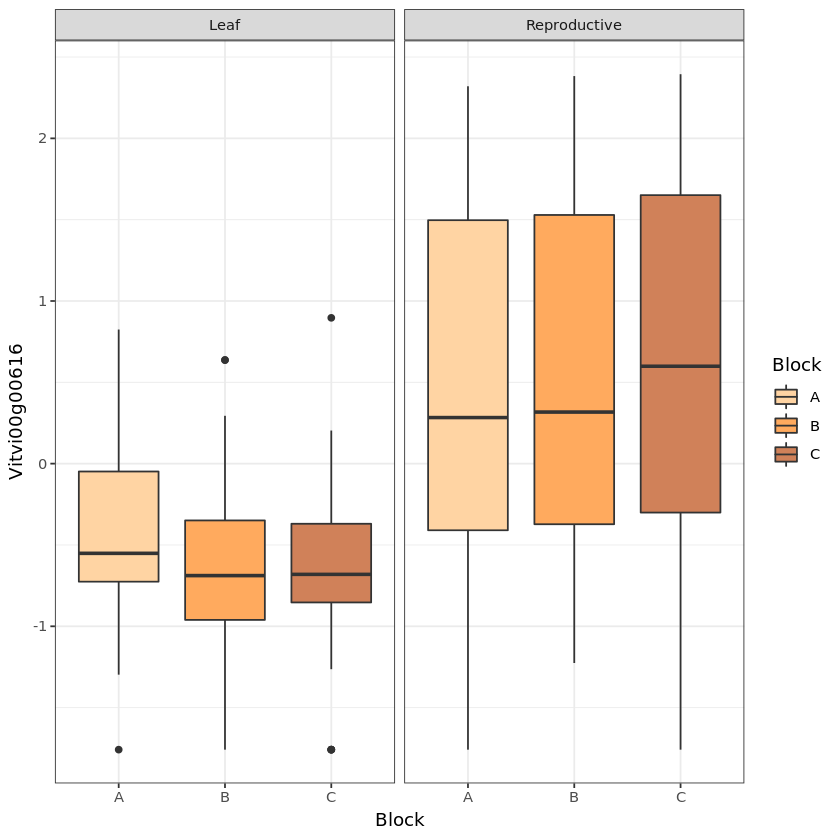

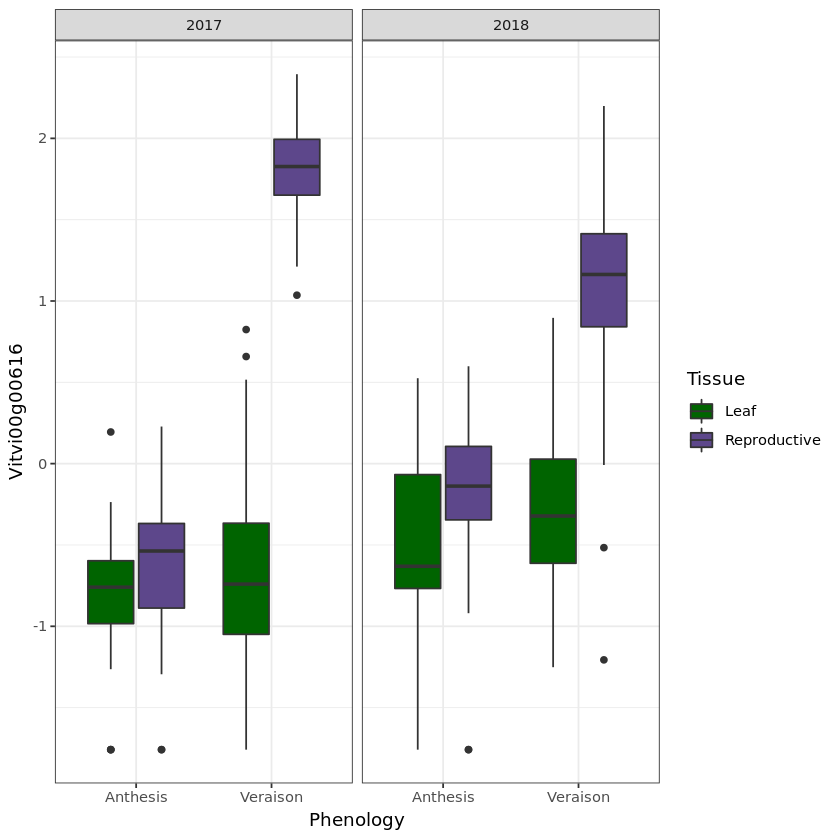

In [163]:
whichPostHocs$Vitvi00g00616

In [76]:
# save(stored_models, file="1718_geneExpression_reproctive_storedModels.Rdata")
# save(whichPostHocs, file="1718_geneExpression_reproctive_whichPostHocs.Rdata")

In [108]:
length(sigGenes$`Phenology:Block_p`)

COUNTER <- 0
genes_for_SOM_PhenologyBlock <- c()
for (gene in sigGenes$`Phenology:Block_p`){
    comp <- whichPostHocs[[gene]]$whichCompSig[['Phenology:Block_p']]
    if (!is.null(comp)){
        genes_for_SOM_PhenologyBlock <- c(genes_for_SOM_PhenologyBlock, gene)
        COUNTER <- COUNTER + 1
    }
}

save(genes_for_SOM_PhenologyBlock, file='1718_geneExpression_reproductive_PhenologyBlock_genes.Rdata')
COUNTER

[1] 5572

[1] 4176

In [96]:
length(genes_for_SOM_YearPhenology)

[1] 12338

[1] "Vitvi00g00795"

In [277]:
c(1, 2, 3, 4, seq(5, 100, 5))

[1]   1   2   3   4   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75
[20]  80  85  90  95 100

In [87]:
m <- matrix(nrow=33, ncol=24)

for (cutoff in c(1, 2, 3, 4, seq(5, 100, 5))){
    if (cutoff < 5){
        col <- cutoff
    } else {
        col <- cutoff/5 + 4
    }
    for (f in levels(df_plot$factor)){
        row <- which(levels(df_plot$factor) == f)
        m[row,col] <- length(df_plot$gene[df_plot$factor == f & df_plot$var > cutoff])
    }
}

m <- as.data.frame(m)

rownames(m) <- levels(df_plot$factor)
colnames(m) <- c(1, 2, 3, 4, seq(5, 100, 5))

m

1     2     3     4     5     10    15    20    25    30    ⋯ 55   60  
I        98     0     0     0     0     0     0     0     0     0 ⋯    0    0
Y     17353 14159 11829 10066  8772  4879  2996  1959  1277   840 ⋯   77   38
P     19935 18266 16897 15751 14755 10846  8182  6145  4571  3375 ⋯  369  197
R        65     3     1     1     1     0     0     0     0     0 ⋯    0    0
B      3687  1573   793   417   247    36     9     3     0     0 ⋯    0    0
T     18472 17082 16017 15119 14406 11571  9331  7574  6151  5042 ⋯ 1645 1211
YP    17561 12541  8899  6245  4409   717   110    14     3     1 ⋯    0    0
YR      263     2     0     0     0     0     0     0     0     0 ⋯    0    0
PR      222     2     0     0     0     0     0     0     0     0 ⋯    0    0
YB      551    24     1     0     0     0     0     0     0     0 ⋯    0    0
PB      800    44     3     0     0     0     0     0     0     0 ⋯    0    0
RB      144     4     1     0     0     0     0     0     0     0 ⋯    0    0
YT    14155 10142  7640  5832  4500  1221   300    51     5     0 ⋯    0    0
PT    18255 15355 13220 11419  9983  5450  3250  1988  1227   696 ⋯    1    0
RT       33     0     0     0     0     0     0     0     0     0 ⋯    0    0
BT     1274   282    85    21     7     1     0     0     0     0 ⋯    0    0
YPR    1588    71     3     1     1     0     0     0     0     0 ⋯    0    0
YPB    3961   493    92    26     9     0     0     0     0     0 ⋯    0    0
YRB    1476    48     1     0     0     0     0     0     0     0 ⋯    0    0
PRB    1596    68     4     0     0     0     0     0     0     0 ⋯    0    0
YPT   13554  7812  4412  2659  1609   137     5     0     0     0 ⋯    0    0
YRT     250    10     0     0     0     0     0     0     0     0 ⋯    0    0
PRT     317     7     1     0     0     0     0     0     0     0 ⋯    0    0
YBT     404    11     0     0     0     0     0     0     0     0 ⋯    0    0
PBT    1111    84     8     3     0     0     0     0     0     0 ⋯    0    0
RBT     204     5     0     0     0     0     0     0     0     0 ⋯    0    0
YPRB   7507  1316   169    23     7     1     1     1     0     0 ⋯    0    0
YPRT    937    73    13     5     2     0     0     0     0     0 ⋯    0    0
YPBT   1895   103    16     5     1     0     0     0     0     0 ⋯    0    0
YRBT   1680    68     3     1     0     0     0     0     0     0 ⋯    0    0
PRBT   1776   139    19     7     2     0     0     0     0     0 ⋯    0    0
YPRBT  4827   611    98    21     8     1     0     0     0     0 ⋯    0    0
Res   22051 22045 22028 21995 21901 20839 18781 16290 13802 11471 ⋯ 4064 3153
      65   70   75  80  85 90 95 100
I        0    0   0   0  0  0 0  0  
Y       16    8   3   0  0  0 0  0  
P       67   23   4   0  0  0 0  0  
R        0    0   0   0  0  0 0  0  
B        0    0   0   0  0  0 0  0  
T      881  589 360 158 44 12 1  0  
YP       0    0   0   0  0  0 0  0  
YR       0    0   0   0  0  0 0  0  
PR       0    0   0   0  0  0 0  0  
YB       0    0   0   0  0  0 0  0  
PB       0    0   0   0  0  0 0  0  
RB       0    0   0   0  0  0 0  0  
YT       0    0   0   0  0  0 0  0  
PT       0    0   0   0  0  0 0  0  
RT       0    0   0   0  0  0 0  0  
BT       0    0   0   0  0  0 0  0  
YPR      0    0   0   0  0  0 0  0  
YPB      0    0   0   0  0  0 0  0  
YRB      0    0   0   0  0  0 0  0  
PRB      0    0   0   0  0  0 0  0  
YPT      0    0   0   0  0  0 0  0  
YRT      0    0   0   0  0  0 0  0  
PRT      0    0   0   0  0  0 0  0  
YBT      0    0   0   0  0  0 0  0  
PBT      0    0   0   0  0  0 0  0  
RBT      0    0   0   0  0  0 0  0  
YPRB     0    0   0   0  0  0 0  0  
YPRT     0    0   0   0  0  0 0  0  
YPBT     0    0   0   0  0  0 0  0  
YRBT     0    0   0   0  0  0 0  0  
PRBT     0    0   0   0  0  0 0  0  
YPRBT    0    0   0   0  0  0 0  0  
Res   2333 1563 746 123  0  0 0  0

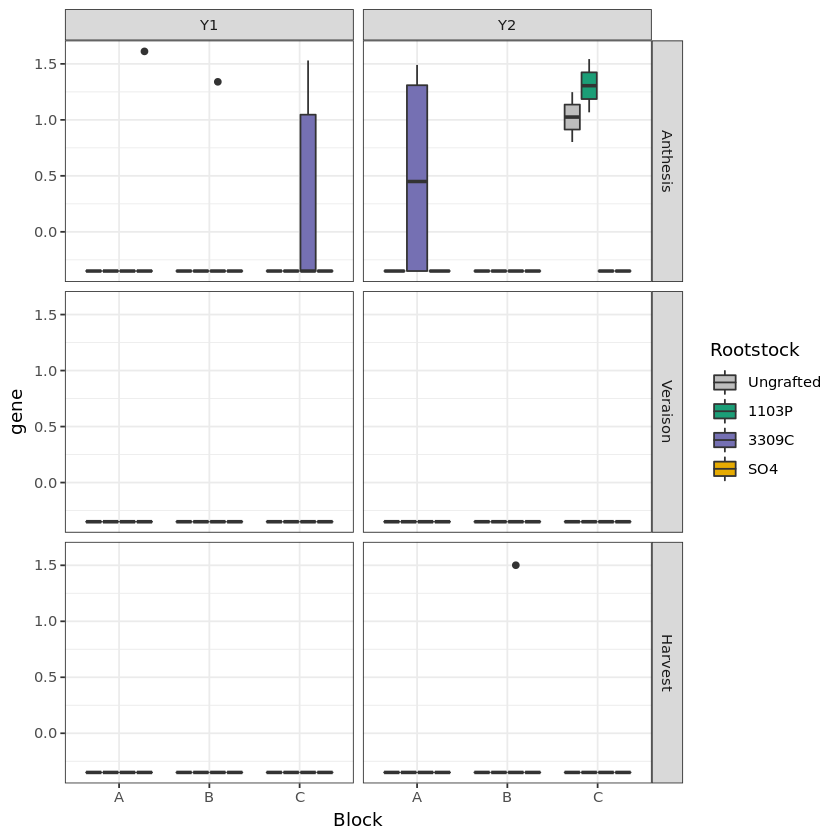

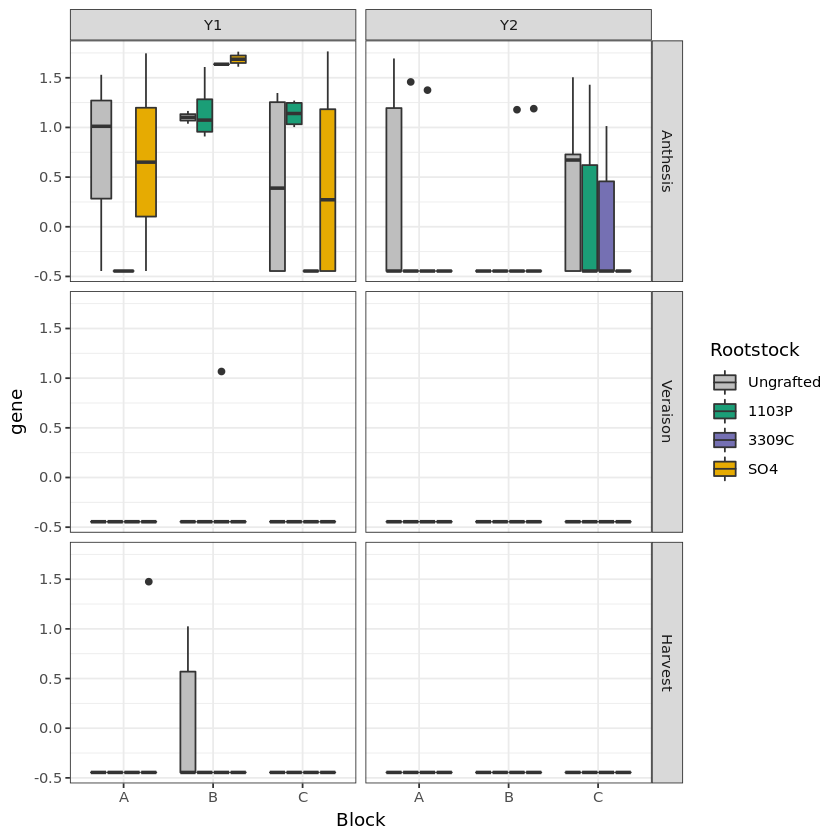

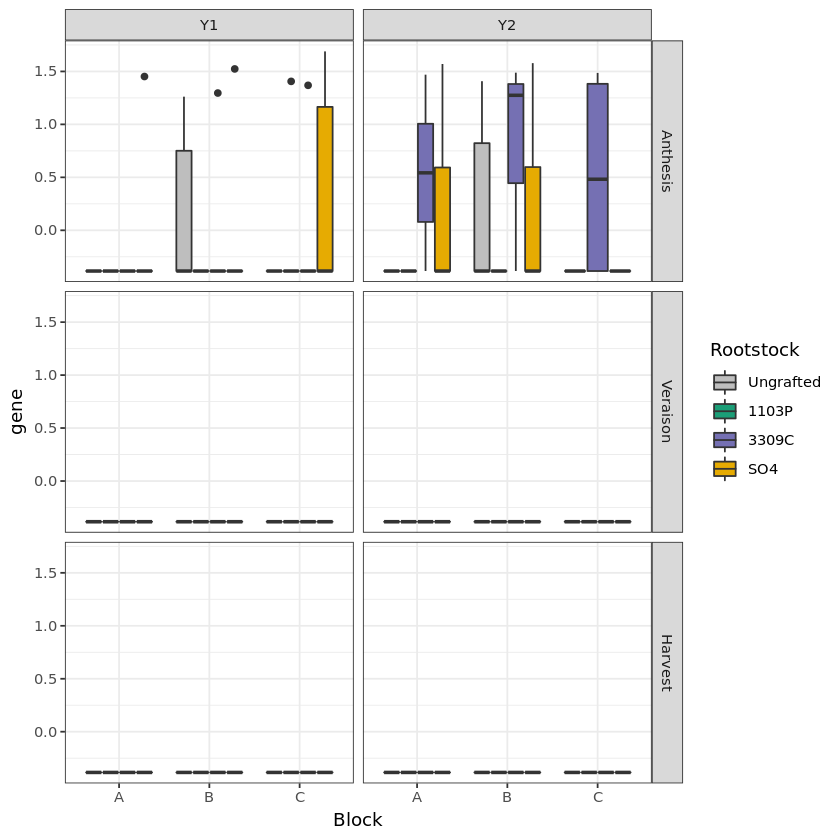

In [311]:
pcheck <- df_noRes$gene[df_noRes$factor == 'YPRB' & df_noRes$var > 20]

#set <- intersect(gpcheck, pcheck)
if(length(pcheck) > 3){
    set <- sample(pcheck, 3)
} else {
    set <- pcheck
}

for (g in set){
    d <- vsd_counts_model %>% select(g, Row:Year)
    colnames(d) <- c('gene', 'Row', 'Rootstock', 'Irrigation', 'Phenology', 'Tissue', 'Block', 'Year')
    
    #standardize
    d$gene <- scale(d$gene, scale=T, center=T)[,1]
    
    #remove anomalies
    d <- anomalize(as_tibble(d), target='gene', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly == 'No',]
    
    p <- ggplot(d, aes_string(x='Block', y='gene', fill='Rootstock')) + 
      geom_boxplot() + 
      facet_grid(rows=vars(Phenology), cols=vars(Year)) + 
      scale_fill_manual(values=rs_palette) + 
      theme_bw()
    print(p)
}

## Can LDA resolve other factors?

In [285]:
d <- vsd_counts_varFilt[,geneVar_filt]
dim(d)

d$sampleName <- rownames(d)
d <- merge(d, (treatments %>% select(sampleName, Rootstock)), on='sampleName')

X_train <- d[train_idx,]
X_test <- d[test_idx,]
y_train <- X_train$Rootstock
y_test <- X_test$Rootstock

X_train$sampleName <- NULL
X_test$sampleName <- NULL
X_train$Rootstock <- NULL
X_test$Rootstock <- NULL

#2 samples were way out of wack: 210 and 234 from train. just removing for now
X_train <- X_train[-c(210, 234),]
y_train <- y_train[-c(210, 234)]

[1]   424 21018

In [286]:
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Rootstock <- y_train

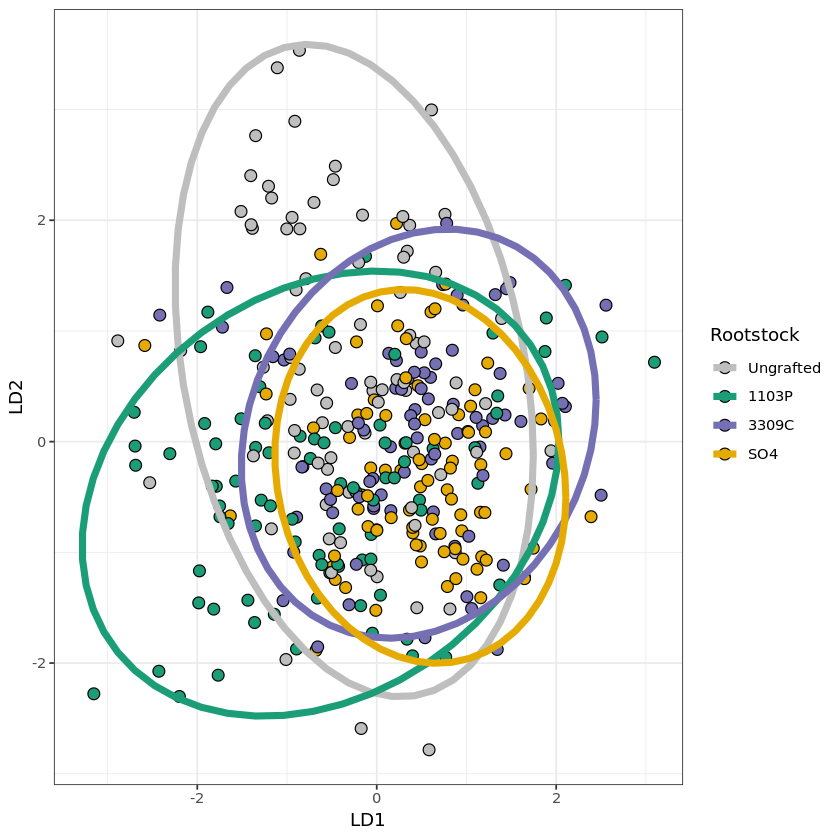

In [289]:
ggplot(d, aes(x=LD1, y=LD2, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=rs_palette) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=rs_palette) + 
  theme_bw()

In [284]:
which(d$LD1 > 3)

[1] 210 234

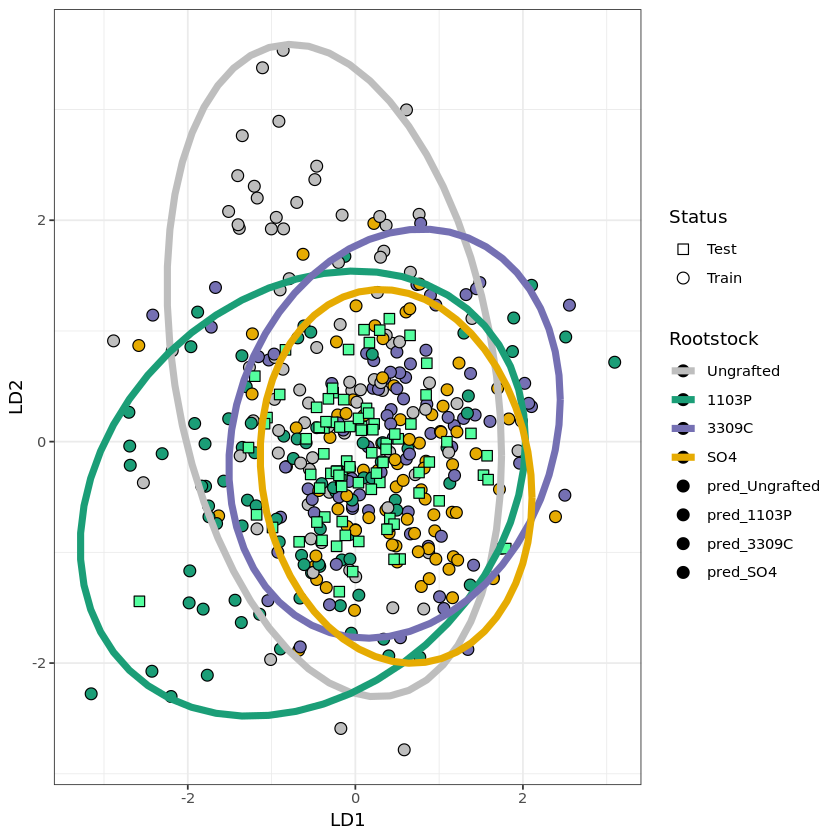

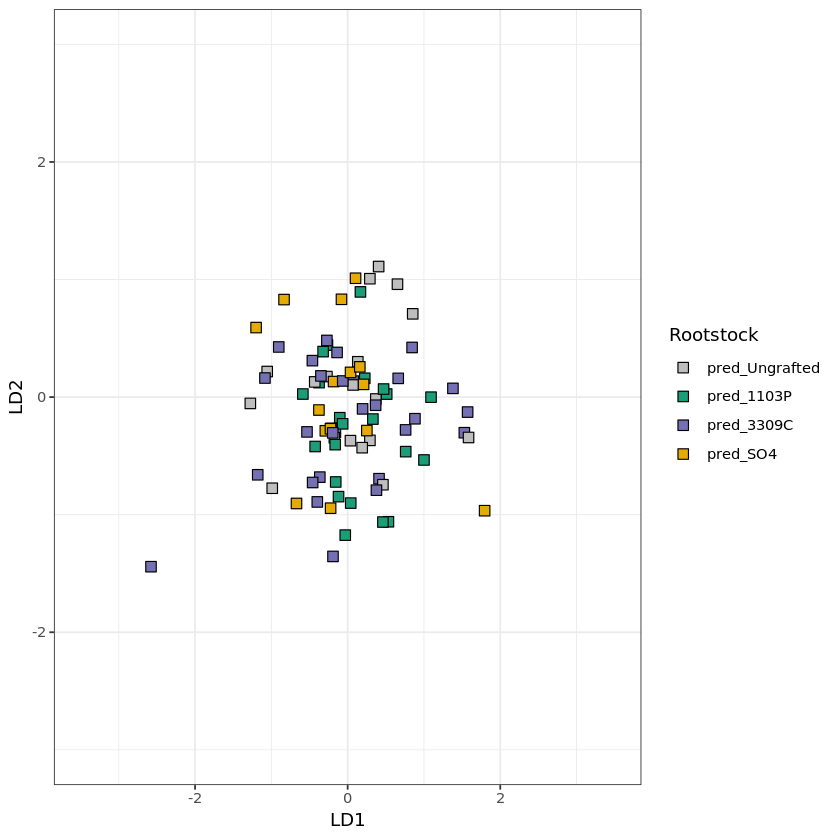

In [295]:
pred <- predict(lda, X_test)
d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Rootstock <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Rootstock <- factor(d_pred$Rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4', paste('pred_', c('Ungrafted', '1103P', '3309C', 'SO4'), sep='')))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

ggplot(d_pred, aes(x=LD1, y=LD2, fill=Rootstock, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(rs_palette, rep('seagreen1', 4))) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=c(rs_palette, rep(NA, 4))) + 
  theme_bw()

ggplot(d_pred[d_pred$Status == 'Test',], aes(x=LD1, y=LD2, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(22, 4)) + 
  scale_fill_manual(values=rs_palette) + 
  xlim(-3.5, 3.5) + ylim(-3, 3) + 
  theme_bw()

In [292]:
caret::confusionMatrix(y_test, pred$class)

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted         6     4     3   5
  1103P             4     9     6   3
  3309C             5    10     6   8
  SO4               6     5     2   2

Overall Statistics
                                         
               Accuracy : 0.2738         
                 95% CI : (0.1821, 0.382)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : 0.9002         
                                         
                  Kappa : 0.033          
                                         
 Mcnemar's Test P-Value : 0.4587         

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                   0.28571       0.3214      0.35294    0.11111
Specificity                   0.80952       0.7679      0.65672    0.80303
Pos Pred Value                0.33333       0.4091      0.20690    0.13333
Neg Pred Value                0.772

In [300]:
d <- vsd_counts_varFilt[,geneVar_filt]
dim(d)

d$sampleName <- rownames(d)
d <- merge(d, (treatments %>% select(sampleName, Year)), on='sampleName')

X_train <- d[train_idx,]
X_test <- d[test_idx,]
y_train <- X_train$Year
y_test <- X_test$Year

X_train$sampleName <- NULL
X_test$sampleName <- NULL
X_train$Year <- NULL
X_test$Year <- NULL

[1]   424 21018

In [301]:
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Year <- y_train

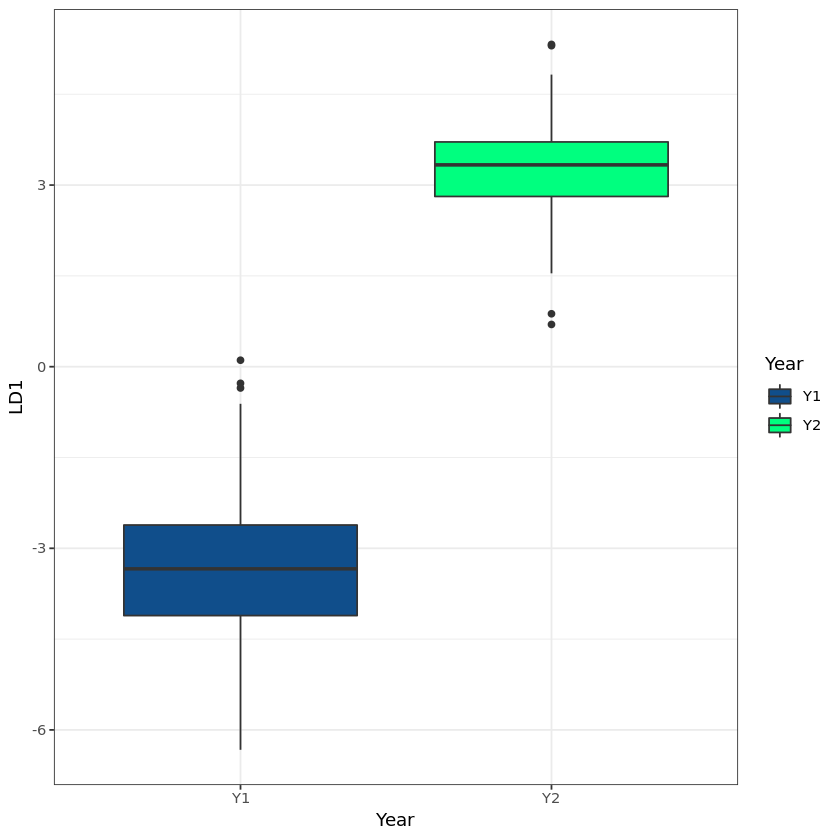

In [305]:
ggplot(d, aes(x=Year, y=LD1, fill=Year)) + 
  geom_boxplot() + 
  scale_fill_manual(values=y_palette) + 
  theme_bw()

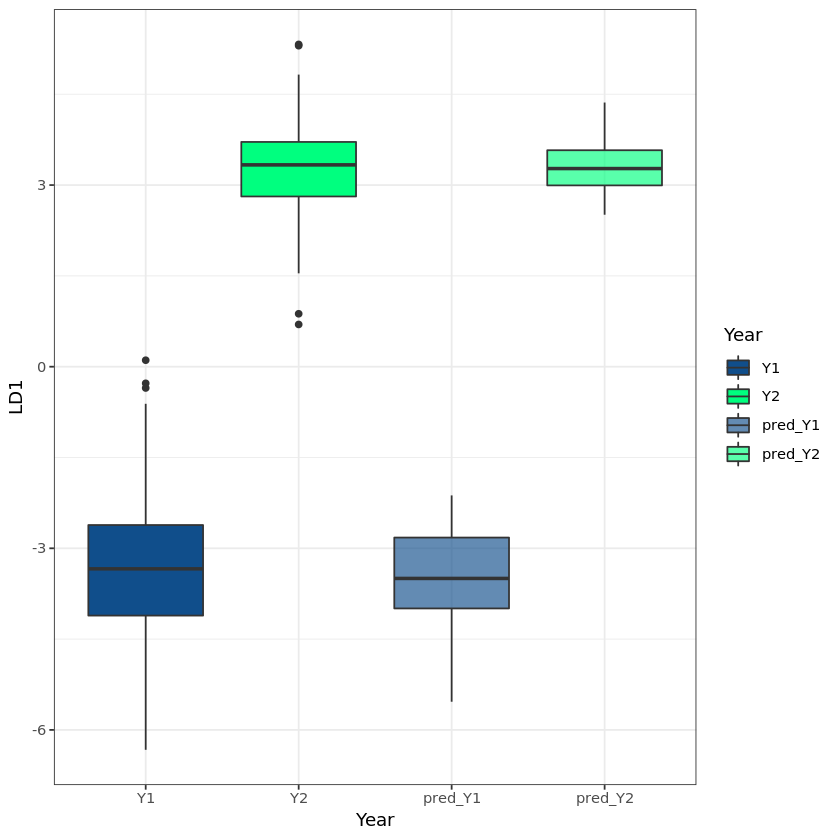

In [310]:
pred <- predict(lda, X_test)
d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Year <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Year <- factor(d_pred$Year, levels=c('Y1', 'Y2', paste('pred_', c('Y1', 'Y2'), sep='')))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

ggplot(d_pred, aes(x=Year, y=LD1, fill=Year, alpha=Year)) + 
  geom_boxplot() + 
  scale_fill_manual(values=c(y_palette, y_palette)) + 
  scale_alpha_manual(values=c(1, 1, 0.65, 0.65)) + 
  theme_bw()

In [302]:
pred <- predict(lda, X_test)
caret::confusionMatrix(y_test, pred$class)

Confusion Matrix and Statistics

          Reference
Prediction Y1 Y2
        Y1 42  0
        Y2  0 42
                                    
               Accuracy : 1         
                 95% CI : (0.957, 1)
    No Information Rate : 0.5       
    P-Value [Acc > NIR] : < 2.2e-16 
                                    
                  Kappa : 1         
                                    
 Mcnemar's Test P-Value : NA        
                                    
            Sensitivity : 1.0       
            Specificity : 1.0       
         Pos Pred Value : 1.0       
         Neg Pred Value : 1.0       
             Prevalence : 0.5       
         Detection Rate : 0.5       
   Detection Prevalence : 0.5       
      Balanced Accuracy : 1.0       
                                    
       'Positive' Class : Y1        
                                    

In [343]:
d <- vsd_counts_varFilt[,geneVar_filt]
dim(d)

d$sampleName <- rownames(d)
d <- merge(d, (treatments %>% select(sampleName, Phenology, Rootstock)), on='sampleName')
d$PR <- paste(d$Phenology, d$Rootstock, sep='')
d$Phenology <- NULL
d$Rootstock <- NULL

X_train <- d[train_idx,]
X_test <- d[test_idx,]
y_train <- X_train$PR
y_test <- X_test$PR

X_train$sampleName <- NULL
X_test$sampleName <- NULL
X_train$PR <- NULL
X_test$PR <- NULL

[1]   424 21018

In [331]:
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$PR <- y_train

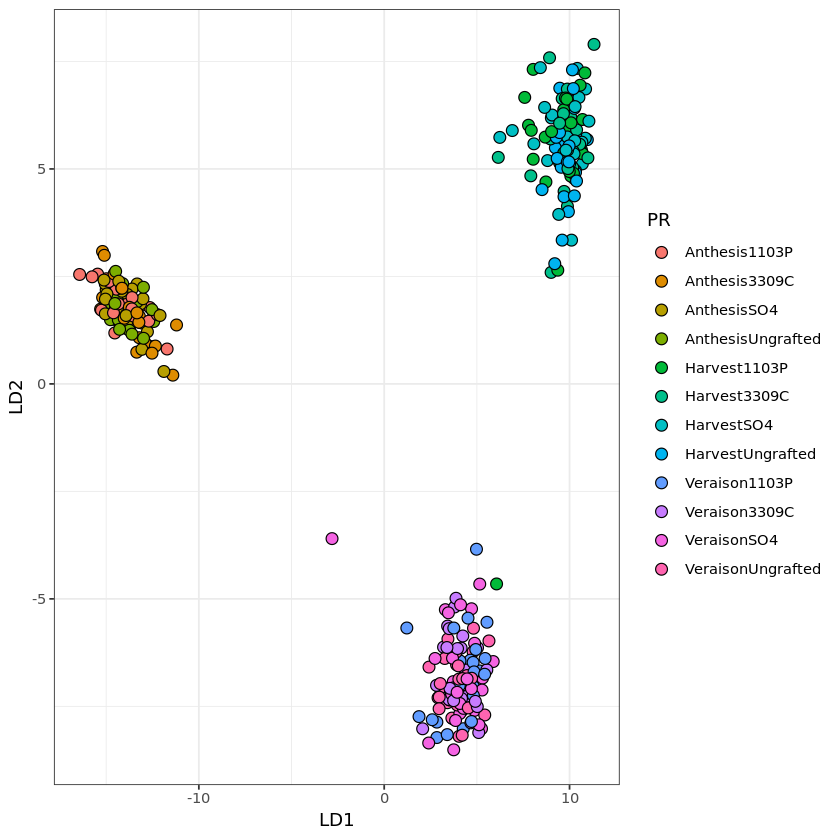

In [334]:
ggplot(d, aes(x=LD1, y=LD2, fill=PR, shape=PR)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=PR), lwd=2) +  
  theme_bw()

In [345]:
levels(pred$class)
y_test <- factor(y_test, levels=c('Anthesis1103P', 'Anthesis3309C', 'AnthesisSO4', 'AnthesisUngrafted',
                                  'Harvest1103P', 'Harvest3309C', 'HarvestSO4', 'HarvestUngrafted', 
                                  'Veraison1103P', 'Veraison3309C', 'VeraisonSO4', 'VeraisonUngrafted'))

[1] "Anthesis1103P"     "Anthesis3309C"     "AnthesisSO4"      
 [4] "AnthesisUngrafted" "Harvest1103P"      "Harvest3309C"     
 [7] "HarvestSO4"        "HarvestUngrafted"  "Veraison1103P"    
[10] "Veraison3309C"     "VeraisonSO4"       "VeraisonUngrafted"

In [354]:
pred <- predict(lda, X_test)
caret::confusionMatrix(y_test, pred$class)


Confusion Matrix and Statistics

                   Reference
Prediction          Anthesis1103P Anthesis3309C AnthesisSO4 AnthesisUngrafted
  Anthesis1103P                 1             0           4                 1
  Anthesis3309C                 4             2           3                 1
  AnthesisSO4                   1             0           1                 4
  AnthesisUngrafted             1             4           0                 2
  Harvest1103P                  0             0           0                 0
  Harvest3309C                  0             0           0                 0
  HarvestSO4                    0             0           0                 0
  HarvestUngrafted              0             0           0                 0
  Veraison1103P                 0             0           0                 0
  Veraison3309C                 0             0           0                 0
  VeraisonSO4                   0             0           0                 0
  